## Import packages

In [25]:
import numpy as np 
import csv 
import glob
import pandas as pd
import os
import sys
from tqdm import tqdm
from joblib import Parallel, delayed
import ast
import hssm
import seaborn as sns 

# Get the path to the parent directory
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

# Add the parent directory to the Python path
sys.path.append(parent_dir)

current_dir = os.getcwd()


# Import utils folder
from utils.twostep_support import *    
from models import *
from MLE import *

## Select AI model type, dataset and drift rate model for AI_ddm

In [ ]:
model = "RL_ddm_biased" # RL, RL_ddm,RL_ddm_biased, AI, or AI_ddm
mtype = 3 # 0, 1, 2 or 3 (only relevant if model = AI or AI_ddm)
drmtype = "linear" # Drift rate model: linear, sigmoid, sigmoid_single_v_mod, sigmoid_single_v_max
n_starts = 35 # Number of random starting parameter values in parameter fitting.
dataset = 'magic_carpet_2020' # Name of the dataset

In [ ]:
if model in ("RL", "RL_ddm", "RL_ddm_biased"):
    learning = "RL"
elif model in ("AI", "AI_ddm"):
    learning = "PSM"

# Load dataset

In [27]:
# Path to dataset

current_dir = os.getcwd()

if dataset == 'magic_carpet_2023':
    
    # Path to where the csv file is relative to the current script's directory
    path_to_data = os.path.abspath(os.path.join(current_dir, 
                                               '../../two_step_task_datasets/' + dataset + '_dataset/task_behaviour'))

    # Use glob to find all CSV files in the folder with the naming pattern
    file_paths = glob.glob(os.path.join(path_to_data, "*story.csv"))

elif dataset == 'magic_carpet_2020':
    
    # Path to where the csv file is relative to the current script's directory
    path_to_data = os.path.abspath(os.path.join(current_dir, 
                                               '../../two_step_task_datasets/' + dataset + '_dataset/choices'))


    
    # Use glob to find all CSV files in the folder with the naming pattern
    file_paths = glob.glob(os.path.join(path_to_data, "*game.csv"))

    
# Create an empty list to hold the dataframes
df_list = []

par_ids = []

# Loop through each file
for file_path in file_paths:
    # Extract the participant ID from the filename (assuming filename format like 001_story.csv)
    participant_id_str = os.path.basename(file_path).split('_')[0]
    
    participant_id = int(participant_id_str)

    if dataset == 'magic_carpet_2020' and participant_id == 4960: # Avoid outlier participant
        continue
        
    par_ids.append(participant_id)
    
    # Read the CSV file into a dataframe
    df = pd.read_csv(file_path)
    
    # Add the ParticipantID column
    df['ParticipantID'] = participant_id
    
    # Append the dataframe to the list
    df_list.append(df)

# Concatenate all dataframes into one
df_empirical_data = pd.concat(df_list, ignore_index=True)


n_par = len(par_ids) # Number of participants


## Data cleaning

In [28]:
if dataset == 'magic_carpet_2020':
    df_empirical_data = df_empirical_data[
        ~(
            ((df_empirical_data['rt1'] < 0.1) | (df_empirical_data['rt1'] == -1)) |
            ((df_empirical_data['rt2'] < 0.1) | (df_empirical_data['rt2'] == -1))
        )
    ]
if dataset == 'magic_carpet_2023':
    df_empirical_data = df_empirical_data[
        ~(
            ((df_empirical_data['rt1'] < 0.1) | (df_empirical_data['rt1'] == "")) |
            ((df_empirical_data['rt2'] < 0.1) | (df_empirical_data['rt2'] == ""))
        )
    ]

## Load fitted parameters

In [29]:
path_to_folder = os.path.abspath(os.path.join(current_dir, '../model_fitting/fitted_parameters/' + dataset + '/'))

file_path_AI = os.path.join(path_to_folder, "fitted_parameters_MAI" + str(mtype) + "_n_starts" + str(n_starts) + ".csv")
df_AI_fitted_parameters = pd.read_csv(file_path_AI)

file_path_AI_ddm = os.path.join(path_to_folder, "fitted_parameters_MAI_ddm" + str(mtype) + "_DRM" + drmtype + "_n_starts" + str(n_starts) + ".csv")
df_AI_ddm_fitted_parameters = pd.read_csv(file_path_AI_ddm)

## Helper functions

In [30]:
def create_empty_nested_dict(pids, list_names):
    """
    Creates a nested dictionary using dictionary comprehensions.
    Outer keys are PIDs, inner keys are list_names,
    and inner values are empty lists.

    Args:
        pids (list): A list of participant IDs (e.g., strings).
        list_names (list): A list of names for the inner lists (e.g., strings).

    Returns:
        dict: The created nested dictionary.
    """
    # For each pid, create an inner dictionary where each list_name maps to an empty list
    main_dict = {
        pid: {name: [] for name in list_names}
        for pid in pids
    }
    return main_dict

In [31]:
def KL_dive(p, q):
    """
    KL(p||q)
    Returns the Kullback-Leibler divergence of two Categorical distribution vectors p and q.
    """
    
    return p[0]*np.log(p[0]/q[0]) + p[1]*np.log(p[1]/q[1]) 

In [32]:
def process_participant(model, mtype, params, observations, actions, sims_per_trial):
    
    """
    Evaluate Delta G given a sequence of actions, observations and parameter sets (performed trial-wise).

    ~~~~~~
    INPUTS
    ~~~~~~
    params: model parameters
    observations: sequence of transition and outcome observations
    actions: sequence of taken actions
    learning: learning algorithm used (Default is "PSM": Predictive-surprise modulated learning)
    mtype: integer specifying submodel
    """

    if mtype == 0:
        lr = params['lr']
        vunsamp = params['vunsamp']
        vsamp = params['vsamp']
        vps = params['vps']
        lam = params['lam']
        kappa_a = params['kappa_a']
        prior_nu = 2
        prior_r = params['prior_r']

    #If mtype > 0:
    else: # We set parameters 0, 1, and 2 later, for now the identical parameters for all mtype>0:
        lr = params['lr']
        lam = params['lam']
        kappa_a = params['kappa_a']
        prior_nu = 2
        prior_r = params['prior_r']

        if mtype == 1: # No Decay for Sampled Actions
            vunsamp = params['vunsamp']
            vsamp = 0
            vps = params['vps']
            
        if mtype == 2: # No Decay for UNsampled Actions
            vunsamp = 0
            vsamp = params['vsamp']
            vps = params['vps']

        if mtype == 3: # No Surprise Learning
            vunsamp = params['vunsamp']
            vsamp = params['vsamp']
            vps = 0

    if model == "AI_ddm":
        v_stage_0 = params["v_stage_0"]
        v_stage_1 = params["v_stage_1"]
        a_bs = params["a_bs"]
        ndt = params["ndt"]
    elif model == "AI":
        gamma1 = params["gamma1"]
        gamma2 = params["gamma2"]
    else:
        raise ValueError("Only possible models are AI or AI_ddm")

    #### ----------
    # Specify task and generate (potential) observations
    T = observations.shape[0]
    
    task_dict = {  
        "type": "drift",
        "T": T,
        "x": False,
        "r": True,
        "delta": 0.025,
        "bounds": [0.25 ,0.75]
    }

    model_dict = { # Model specification
        "act": 'AI',
        "learn": "PSM",
        "learn_transitions": False,
        "lr": lr,
        "vunsamp": vunsamp,
        "vsamp": vsamp,
        "vps": vps, 
        "lam": lam,
        "kappa_a": kappa_a,
        "prior_r": prior_r
    }

    temp = models.learn_and_act(task_dict, model_dict)

    
    EFEs = np.ones((T,6))

    prev_EFEs = - np.ones(6)

    po = np.zeros(2)
    pa = np.zeros(2)

    delta_G_stage_1 = np.zeros(T)
    delta_G_stage_2 = np.zeros(T)

    min_EFE_action_chosen_stage_1 = np.zeros(T)  
    min_EFE_action_chosen_stage_2 = np.zeros(T)

    sim_p_min_EFE_action_chosen_stage_1 = np.zeros(T)  
    sim_p_min_EFE_action_chosen_stage_2 = np.zeros(T)  

    mean_sim_rts_stage_1 = np.zeros(T)  
    mean_sim_rts_stage_2 = np.zeros(T) 
    
    Gs_stage_1 = np.zeros((T,2)) 
    Gs_stage_2 = np.zeros((T,2)) 

    Es_stage_1 = np.zeros((T,2)) 
    Es_stage_2 = np.zeros((T,2))
    
    cog_effort_stage_1 = np.zeros(T)

    update_prior_effort_stage_1 = np.zeros(T)
    update_prior_effort_stage_2 = np.zeros(T)

    prev_a = 0
    
    for n in range(T):
        
        # Check which actions were taken and which outcomes were observed
        po = observations[n,:].astype(int)
        pa = actions[n,:].astype(int)

        Gs = temp.perform_trial_return_EFE_or_Q(n, pa, po)

        EFEs[n,0] = Gs[n, 0, 0]
        EFEs[n,1] = Gs[n, 0, 1]
        EFEs[n,2] = Gs[n, 1, 0]
        EFEs[n,3] = Gs[n, 1, 1]
        EFEs[n,4] = Gs[n, 2, 0]
        EFEs[n,5] = Gs[n, 2, 1]

        #-------------------Calculate Formalisms----------------------#

        G_stage_1_diff = EFEs[n,0] - EFEs[n,1]

        Gs_stage_1[n,0] = EFEs[n, 0]
        Gs_stage_1[n,1] = EFEs[n, 1]

        # Habits
        E = np.zeros(2)
        if n > 0:
            E[prev_a] += - np.exp(kappa_a)
            E[int(1-prev_a)] += - np.exp(-kappa_a)
        
        prev_a = pa[0]

        observed_tran = observations[n,0]

        if observed_tran == 0:
            
            G_stage_2_diff = EFEs[n, 2] - EFEs[n, 3]
            
            Gs_stage_2[n,0] = EFEs[n, 2]
            Gs_stage_2[n,1] = EFEs[n, 3]
        
        if observed_tran == 1:
            
            G_stage_2_diff = EFEs[n, 4] - EFEs[n, 5]
            
            Gs_stage_2[n,0] = EFEs[n, 4]
            Gs_stage_2[n,1] = EFEs[n, 5]
        
        if n == 0:
            cog_effort_stage_1[n] = np.nan
            update_prior_effort_stage_1[n] = np.nan
            update_prior_effort_stage_2[n] = np.nan

        else: 
            cog_effort_stage_1[n] = KL_dive(np.exp(-EFEs[n,:2])/np.sum(np.exp(-EFEs[n,:2])), np.exp(E)/np.sum(np.exp(E)))
            update_prior_effort_stage_1[n] = KL_dive(np.exp(-EFEs[n,:2])/np.sum(np.exp(-EFEs[n,:2])), np.exp(-prev_EFEs[:2])/np.sum(np.exp(-prev_EFEs[:2])))

            if observed_tran == 0:
                if prev_EFEs[2] == -1 or prev_EFEs[3] == -1:
                    update_prior_effort_stage_2[n] = np.nan               
                else:
                    update_prior_effort_stage_2[n] = KL_dive(np.exp(-EFEs[n,2:4])/np.sum(np.exp(-EFEs[n,2:4])), np.exp(-prev_EFEs[2:4])/np.sum(np.exp(-prev_EFEs[2:4])))
            
            if observed_tran == 1:
                
                if prev_EFEs[4] == -1 or prev_EFEs[5] == -1:
                    update_prior_effort_stage_2[n] = np.nan         
                else:
                    update_prior_effort_stage_2[n] = KL_dive(np.exp(-EFEs[n,4:6])/np.sum(np.exp(-EFEs[n,4:6])), np.exp(-prev_EFEs[4:6])/np.sum(np.exp(-prev_EFEs[4:6])))
        
        prev_EFEs = EFEs[n,:]
            
        delta_G_stage_1[n] = abs(G_stage_1_diff)
        delta_G_stage_2[n] = abs(G_stage_2_diff)
 

        if G_stage_1_diff < 0:
            if actions[n,0] == 0:
                min_EFE_action_chosen_stage_1[n] = 1
        else:
            if actions[n,0] == 1:
                min_EFE_action_chosen_stage_1[n] = 1

        if G_stage_2_diff < 0:
            if actions[n,1] == 0:
                min_EFE_action_chosen_stage_2[n] = 1
        else:
            if actions[n,1] == 1:
                min_EFE_action_chosen_stage_2[n] = 1


        #-------------------Perform Simulations----------------------#

        
        if model == "AI_ddm":

            # Calculate drift rates (linear)
            v0 = v_stage_0*G_stage_1_diff
            v1 = v_stage_1*G_stage_2_diff
            
            # Simulate stage 1 of the trial
            sim_min_EFE_action_chosen = np.zeros(sims_per_trial)
            sim_trial_rts = np.zeros(sims_per_trial)

            for i in range(sims_per_trial):
                
                param_dict = dict(v=v0, a=a_bs, z=0.5, t=ndt)

                # Simulate trial
                ddm_simulation = hssm.simulate_data(model="ddm", theta=param_dict, size=1,random_state= random.randint(1, 9999999))

                sim_trial_rts[i] = ddm_simulation['rt'].iloc[0]

                sim_response = ddm_simulation['response'].iloc[0] 

                if G_stage_1_diff < 0:
                    if sim_response == -1:
                        sim_min_EFE_action_chosen[i] = 1
                else:
                    if sim_response == 1:
                        sim_min_EFE_action_chosen[i] = 1
                        
            sim_p_min_EFE_action_chosen_stage_1[n] = np.sum(sim_min_EFE_action_chosen)/sims_per_trial
            
            mean_sim_rts_stage_1[n] = np.average(sim_trial_rts)

            # Simulate stage 2 of the trial

            sim_min_EFE_action_chosen = np.zeros(sims_per_trial)
            sim_trial_rts = np.zeros(sims_per_trial)

            for i in range(sims_per_trial):
                
                param_dict = dict(v=v1, a=a_bs, z=0.5, t=ndt)

                # Simulate trial
                ddm_simulation = hssm.simulate_data(model="ddm", theta=param_dict, size=1,random_state= random.randint(1, 9999999))

                sim_trial_rts[i] = ddm_simulation['rt'].iloc[0]

                sim_response = ddm_simulation['response'].iloc[0] 

                if G_stage_2_diff < 0:
                    if sim_response == -1:
                        sim_min_EFE_action_chosen[i] = 1
                else:
                    if sim_response == 1:
                        sim_min_EFE_action_chosen[i] = 1
                        
            sim_p_min_EFE_action_chosen_stage_2[n] = np.sum(sim_min_EFE_action_chosen)/sims_per_trial
            
            mean_sim_rts_stage_2[n] = np.average(sim_trial_rts)
            
        if model == "AI":

            # Simulate stage 1 of the trial
            
            sim_min_EFE_action_chosen = np.zeros(sims_per_trial)

            # Calculate probabilities og chossing something
            Gg = np.clip(-Gs_stage_1[n]  * gamma1,-500,500)
            probs = np.exp(Gg)/np.sum(np.exp(Gg))

            for i in range(sims_per_trial):
                
                sim_response = np.random.choice(np.arange(2),p=probs)
                
                if G_stage_1_diff < 0:
                    if sim_response == 0:
                        sim_min_EFE_action_chosen[i] = 1
                else:
                    if sim_response == 1:
                        sim_min_EFE_action_chosen[i] = 1
                        
            sim_p_min_EFE_action_chosen_stage_1[n] = np.sum(sim_min_EFE_action_chosen)/sims_per_trial

            # Simulate stage 2 of the trial
            
            sim_min_EFE_action_chosen = np.zeros(sims_per_trial)

            # Calculate probabilities of choosing something
            Gg = np.clip(-Gs_stage_2[n]  * gamma2,-500,500)
            probs = np.exp(Gg)/np.sum(np.exp(Gg))

            for i in range(sims_per_trial):
                
                sim_response = np.random.choice(np.arange(2),p=probs)
                
                if G_stage_2_diff < 0:
                    if sim_response == 0:
                        sim_min_EFE_action_chosen[i] = 1
                else:
                    if sim_response == 1:
                        sim_min_EFE_action_chosen[i] = 1
                        
            sim_p_min_EFE_action_chosen_stage_2[n] = np.sum(sim_min_EFE_action_chosen)/sims_per_trial
         
    if model == "AI_ddm":   
        return {
            'delta_AI_ddm_G_stage_1': delta_G_stage_1,
            'delta_AI_ddm_G_stage_2': delta_G_stage_2,
            'min_AI_ddm_EFE_action_chosen_stage_1': min_EFE_action_chosen_stage_1,
            'min_AI_ddm_EFE_action_chosen_stage_2': min_EFE_action_chosen_stage_2,
            'sim_p_min_AI_ddm_EFE_action_chosen_stage_1': sim_p_min_EFE_action_chosen_stage_1,
            'sim_p_min_AI_ddm_EFE_action_chosen_stage_2': sim_p_min_EFE_action_chosen_stage_2,
            'update_prior_effort_AI_ddm_stage_1': update_prior_effort_stage_1,
            'update_prior_effort_AI_ddm_stage_2': update_prior_effort_stage_2,
            'cog_effort_AI_ddm_stage_1': cog_effort_stage_1,
            'mean_AI_ddm_sim_rts_stage_1': mean_sim_rts_stage_1,
            'mean_AI_ddm_sim_rts_stage_2': mean_sim_rts_stage_2
        }
    else:  
        return {
            'delta_AI_G_stage_1': delta_G_stage_1,
            'delta_AI_G_stage_2': delta_G_stage_2,
            'min_AI_EFE_action_chosen_stage_1': min_EFE_action_chosen_stage_1,
            'min_AI_EFE_action_chosen_stage_2': min_EFE_action_chosen_stage_2,
            'sim_p_min_AI_EFE_action_chosen_stage_1': sim_p_min_EFE_action_chosen_stage_1,
            'sim_p_min_AI_EFE_action_chosen_stage_2': sim_p_min_EFE_action_chosen_stage_2,
            'update_prior_effort_AI_stage_1': update_prior_effort_stage_1,
            'update_prior_effort_AI_stage_2': update_prior_effort_stage_2,
            'cog_effort_AI_stage_1': cog_effort_stage_1
        }
           
        

## Model prediction checks

#### 1. Quantile-Quantile (Q-Q) plots for simulated vs empirical RTs 

- For each participant calculate nine RT percentiles (.1 to .9)
- Simulate 50 experiments with 1000 trials each, using the fitted parameters of each participant and calculate the RT percentiles

In [33]:
empirical_RT_percentiles = np.zeros((n_par, 19))

columns = [
    "ParticipantID",
    "Percentile_10_rt1",
    "Percentile_20_rt1",
    "Percentile_30_rt1",
    "Percentile_40_rt1",
    "Percentile_50_rt1",
    "Percentile_60_rt1",
    "Percentile_70_rt1",
    "Percentile_80_rt1",
    "Percentile_90_rt1",    
    "Percentile_10_rt2",
    "Percentile_20_rt2",
    "Percentile_30_rt2",
    "Percentile_40_rt2",
    "Percentile_50_rt2",
    "Percentile_60_rt2",
    "Percentile_70_rt2",
    "Percentile_80_rt2",
    "Percentile_90_rt2",  
]

df_empirical_RT_percentiles = pd.DataFrame(empirical_RT_percentiles, columns = columns)

df_empirical_RT_percentiles['ParticipantID'] = par_ids


for par in par_ids:
    
    df_par = df_empirical_data[df_empirical_data["ParticipantID"] == par]
    
    df_empirical_RT_percentiles.loc[df_empirical_RT_percentiles['ParticipantID']==par,"Percentile_10_rt2"] = df_par['rt2'].quantile(0.10)
    df_empirical_RT_percentiles.loc[df_empirical_RT_percentiles['ParticipantID']==par,"Percentile_20_rt2"] = df_par['rt2'].quantile(0.20)
    df_empirical_RT_percentiles.loc[df_empirical_RT_percentiles['ParticipantID']==par,"Percentile_30_rt2"] = df_par['rt2'].quantile(0.30)
    df_empirical_RT_percentiles.loc[df_empirical_RT_percentiles['ParticipantID']==par,"Percentile_40_rt2"] = df_par['rt2'].quantile(0.40)
    df_empirical_RT_percentiles.loc[df_empirical_RT_percentiles['ParticipantID']==par,"Percentile_50_rt2"] = df_par['rt2'].quantile(0.50)
    df_empirical_RT_percentiles.loc[df_empirical_RT_percentiles['ParticipantID']==par,"Percentile_60_rt2"] = df_par['rt2'].quantile(0.60)
    df_empirical_RT_percentiles.loc[df_empirical_RT_percentiles['ParticipantID']==par,"Percentile_70_rt2"] = df_par['rt2'].quantile(0.70)
    df_empirical_RT_percentiles.loc[df_empirical_RT_percentiles['ParticipantID']==par,"Percentile_80_rt2"] = df_par['rt2'].quantile(0.80)
    df_empirical_RT_percentiles.loc[df_empirical_RT_percentiles['ParticipantID']==par,"Percentile_90_rt2"] = df_par['rt2'].quantile(0.90)

    df_empirical_RT_percentiles.loc[df_empirical_RT_percentiles['ParticipantID']==par,"Percentile_10_rt1"] = df_par['rt1'].quantile(0.10)
    df_empirical_RT_percentiles.loc[df_empirical_RT_percentiles['ParticipantID']==par,"Percentile_20_rt1"] = df_par['rt1'].quantile(0.20)
    df_empirical_RT_percentiles.loc[df_empirical_RT_percentiles['ParticipantID']==par,"Percentile_30_rt1"] = df_par['rt1'].quantile(0.30)
    df_empirical_RT_percentiles.loc[df_empirical_RT_percentiles['ParticipantID']==par,"Percentile_40_rt1"] = df_par['rt1'].quantile(0.40)
    df_empirical_RT_percentiles.loc[df_empirical_RT_percentiles['ParticipantID']==par,"Percentile_50_rt1"] = df_par['rt1'].quantile(0.50)
    df_empirical_RT_percentiles.loc[df_empirical_RT_percentiles['ParticipantID']==par,"Percentile_60_rt1"] = df_par['rt1'].quantile(0.60)
    df_empirical_RT_percentiles.loc[df_empirical_RT_percentiles['ParticipantID']==par,"Percentile_70_rt1"] = df_par['rt1'].quantile(0.70)
    df_empirical_RT_percentiles.loc[df_empirical_RT_percentiles['ParticipantID']==par,"Percentile_80_rt1"] = df_par['rt1'].quantile(0.80)
    df_empirical_RT_percentiles.loc[df_empirical_RT_percentiles['ParticipantID']==par,"Percentile_90_rt1"] = df_par['rt1'].quantile(0.90)

In [34]:
sims_per_trial_qq_plots = 1000

simulated_RT_percentiles = np.zeros((n_par, 19))

df_simulated_RT_percentiles = pd.DataFrame(simulated_RT_percentiles, columns = columns)

df_simulated_RT_percentiles['ParticipantID'] = par_ids  

for par in tqdm(par_ids):

    task_dict = {
        "type": "drift", # How outcome probabilities vary
        "T": sims_per_trial_qq_plots, # number of trials
        "x": False, # Whether transition probabilities are resampled
        "r": True, # Whether outcome probabilities are resampled
        "delta": 0.025, # The volatility of task statistics (variance of Gaussian for drift-version aka, diffusion rate)
        "bounds": [0.25,0.75]# List of 2 floats; lower and upper bounds of (final-stage) outcome probabilities
    }
    
    model_dict = {
        "act": model,
        "learn": learning,
        "drmtype": drmtype,
        "learn_transitions": True
    }
        
    # Get the fitted parameters for the participant
    if model == "AI_ddm":
        df_par_fitted_params = df_AI_ddm_fitted_parameters[df_AI_ddm_fitted_parameters['ParticipantID'] == par]
    else:
        df_par_fitted_params = df_fitted_parameters[df_fitted_parameters['ParticipantID'] == par]

    if model == "AI_ddm":

        model_dict['lr'] = df_par_fitted_params["Fitted_lr"].iloc[0]
        model_dict['lam'] = df_par_fitted_params["Fitted_lam"].iloc[0]
        model_dict['kappa_a'] = df_par_fitted_params["Fitted_kappa_a"].iloc[0] 
        model_dict['prior_r'] = df_par_fitted_params["Fitted_prior_r"].iloc[0]
        model_dict['a_bs'] = df_par_fitted_params["Fitted_a_bs"].iloc[0]
        model_dict['v_stage_0'] = df_par_fitted_params["Fitted_v_stage_0"].iloc[0]
        model_dict['v_stage_1'] = df_par_fitted_params["Fitted_v_stage_1"].iloc[0]
        model_dict['ndt'] = df_par_fitted_params["Fitted_ndt"].iloc[0]
        
        if mtype == 0:
            model_dict['vunsamp'] = df_par_fitted_params["Fitted_vunsamp"].iloc[0] 
            model_dict['vsamp'] = df_par_fitted_params["Fitted_vsamp"].iloc[0] 
            model_dict['vps'] = df_par_fitted_params["Fitted_vps"].iloc[0]

        elif mtype == 1:
            model_dict['vunsamp'] = df_par_fitted_params["Fitted_vunsamp"].iloc[0]  
            model_dict['vsamp'] = 0
            model_dict['vps'] = df_par_fitted_params["Fitted_vps"].iloc[0]
       
        elif mtype == 2:
            model_dict['vunsamp'] = 0 
            model_dict["vsamp"] = df_par_fitted_params["Fitted_vsamp"].iloc[0]
            model_dict["vps"] = df_par_fitted_params["Fitted_vps"].iloc[0]

        elif mtype == 3:
            model_dict["vunsamp"] = df_par_fitted_params["Fitted_vunsamp"].iloc[0] 
            model_dict["vsamp"] = df_par_fitted_params["Fitted_vsamp"].iloc[0]
            model_dict["vps"] = 0

    rt2_array = np.zeros((50,sims_per_trial_qq_plots))
    rt1_array = np.zeros((50,sims_per_trial_qq_plots))
    
    for e in range(50):

        agent = learn_and_act(task = task_dict, model = model_dict)
        
        actions, observations, rts, pi, p_trans, p_r, Gs = agent.perform_task()

        rt2_array[e,:] = rts[:,1]
        rt1_array[e,:] = rts[:,0]

    flat_rt2_array = rt2_array.flatten()
    flat_rt1_array = rt1_array.flatten()

    df_simulated_RT_percentiles.loc[df_simulated_RT_percentiles['ParticipantID']==par,"Percentile_10_rt1"] = np.percentile(flat_rt1_array, 10)
    df_simulated_RT_percentiles.loc[df_simulated_RT_percentiles['ParticipantID']==par,"Percentile_20_rt1"] = np.percentile(flat_rt1_array, 20) 
    df_simulated_RT_percentiles.loc[df_simulated_RT_percentiles['ParticipantID']==par,"Percentile_30_rt1"] = np.percentile(flat_rt1_array, 30) 
    df_simulated_RT_percentiles.loc[df_simulated_RT_percentiles['ParticipantID']==par,"Percentile_40_rt1"] = np.percentile(flat_rt1_array, 40) 
    df_simulated_RT_percentiles.loc[df_simulated_RT_percentiles['ParticipantID']==par,"Percentile_50_rt1"] = np.percentile(flat_rt1_array, 50) 
    df_simulated_RT_percentiles.loc[df_simulated_RT_percentiles['ParticipantID']==par,"Percentile_60_rt1"] = np.percentile(flat_rt1_array, 60) 
    df_simulated_RT_percentiles.loc[df_simulated_RT_percentiles['ParticipantID']==par,"Percentile_70_rt1"] = np.percentile(flat_rt1_array, 70) 
    df_simulated_RT_percentiles.loc[df_simulated_RT_percentiles['ParticipantID']==par,"Percentile_80_rt1"] = np.percentile(flat_rt1_array, 80)
    df_simulated_RT_percentiles.loc[df_simulated_RT_percentiles['ParticipantID']==par,"Percentile_90_rt1"] = np.percentile(flat_rt1_array, 90)
    
    df_simulated_RT_percentiles.loc[df_simulated_RT_percentiles['ParticipantID']==par,"Percentile_10_rt2"] = np.percentile(flat_rt2_array, 10)
    df_simulated_RT_percentiles.loc[df_simulated_RT_percentiles['ParticipantID']==par,"Percentile_20_rt2"] = np.percentile(flat_rt2_array, 20) 
    df_simulated_RT_percentiles.loc[df_simulated_RT_percentiles['ParticipantID']==par,"Percentile_30_rt2"] = np.percentile(flat_rt2_array, 30) 
    df_simulated_RT_percentiles.loc[df_simulated_RT_percentiles['ParticipantID']==par,"Percentile_40_rt2"] = np.percentile(flat_rt2_array, 40) 
    df_simulated_RT_percentiles.loc[df_simulated_RT_percentiles['ParticipantID']==par,"Percentile_50_rt2"] = np.percentile(flat_rt2_array, 50) 
    df_simulated_RT_percentiles.loc[df_simulated_RT_percentiles['ParticipantID']==par,"Percentile_60_rt2"] = np.percentile(flat_rt2_array, 60) 
    df_simulated_RT_percentiles.loc[df_simulated_RT_percentiles['ParticipantID']==par,"Percentile_70_rt2"] = np.percentile(flat_rt2_array, 70) 
    df_simulated_RT_percentiles.loc[df_simulated_RT_percentiles['ParticipantID']==par,"Percentile_80_rt2"] = np.percentile(flat_rt2_array, 80)
    df_simulated_RT_percentiles.loc[df_simulated_RT_percentiles['ParticipantID']==par,"Percentile_90_rt2"] = np.percentile(flat_rt2_array, 90)

filename = f"simulated_RT_percentiles_AI_ddm{mtype}.csv" 
output_dir = f"simulation_results/" 
       
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
       
full_path = os.path.join(output_dir, filename)

df_simulated_RT_percentiles.to_csv(full_path, index=False)         

  0%|          | 0/23 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [62]:
df_simulated_RT_percentiles = pd.read_csv(f"simulation_results/simulated_RT_percentiles_AI_ddm{mtype}.csv")

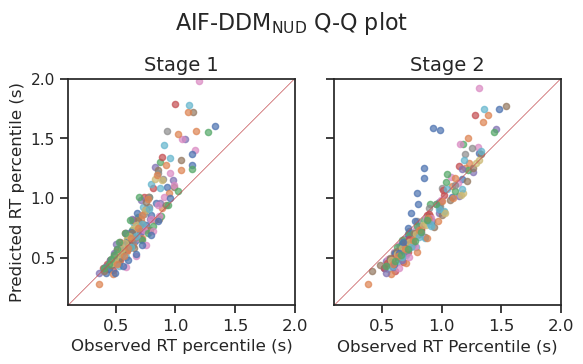

In [64]:
rts_ticks = np.arange(0.5, 2.01, 0.5)

fig, ax = plt.subplots(1, 2, figsize=(6, 4)) 

if mtype == 0:  
    model_string = r"$\text{AIF-DDM}_{\text{FULL}}$"
elif mtype == 1:
    model_string = r"$\text{AIF-DDM}_{\text{NSD}}$"
elif mtype == 2:
    model_string = r"$\text{AIF-DDM}_{\text{NUD}}$"
elif mtype == 3:
    model_string = r"$\text{AIF-DDM}_{\text{NSL}}$"

fig.suptitle(model_string+" Q-Q plot", fontsize=16, y=0.9)

# --- Plot 1: Stage 1 (on ax[0]) ---
for par in par_ids:
    df_par_simulated_percentiles = df_simulated_RT_percentiles[df_simulated_RT_percentiles['ParticipantID'] == par]
    df_par_empirical_percentiles = df_empirical_RT_percentiles[df_empirical_RT_percentiles['ParticipantID'] == par]

    # Check if dataframes are empty for the participant
    if df_par_simulated_percentiles.empty or df_par_empirical_percentiles.empty:
        print(f"Warning: No data for participant {par} for Stage 1. Skipping.")
        continue

    simulated_percentiles_rt1 = [
        df_par_simulated_percentiles['Percentile_10_rt1'].iloc[0],
        df_par_simulated_percentiles['Percentile_20_rt1'].iloc[0],
        df_par_simulated_percentiles['Percentile_30_rt1'].iloc[0],
        df_par_simulated_percentiles['Percentile_40_rt1'].iloc[0],
        df_par_simulated_percentiles['Percentile_50_rt1'].iloc[0],
        df_par_simulated_percentiles['Percentile_60_rt1'].iloc[0],
        df_par_simulated_percentiles['Percentile_70_rt1'].iloc[0],
        df_par_simulated_percentiles['Percentile_80_rt1'].iloc[0],
        df_par_simulated_percentiles['Percentile_90_rt1'].iloc[0]
    ]

    empirical_percentiles_rt1 = [
        df_par_empirical_percentiles['Percentile_10_rt1'].iloc[0],
        df_par_empirical_percentiles['Percentile_20_rt1'].iloc[0],
        df_par_empirical_percentiles['Percentile_30_rt1'].iloc[0],
        df_par_empirical_percentiles['Percentile_40_rt1'].iloc[0],
        df_par_empirical_percentiles['Percentile_50_rt1'].iloc[0],
        df_par_empirical_percentiles['Percentile_60_rt1'].iloc[0],
        df_par_empirical_percentiles['Percentile_70_rt1'].iloc[0],
        df_par_empirical_percentiles['Percentile_80_rt1'].iloc[0],
        df_par_empirical_percentiles['Percentile_90_rt1'].iloc[0]
    ]
    # Plot on the first subplot (ax[0])
    ax[0].scatter(empirical_percentiles_rt1, simulated_percentiles_rt1, s=20, alpha=0.7) # s for size, alpha for transparency

ax[0].set_xlim(0.1, 2)
ax[0].set_ylim(0.1, 2)
ax[0].set_title("Stage 1",fontsize =14)
ax[0].set_ylabel("Predicted RT percentile (s)",fontsize =12)
ax[0].set_xlabel("Observed RT percentile (s)",fontsize =12)
ax[0].set_xticks(rts_ticks,labels=rts_ticks,fontsize =12)
ax[0].set_yticks(rts_ticks)
ax[0].plot([0, 2], [0, 2], 'r-', linewidth=0.5)
ax[0].set_aspect('equal', adjustable='box') # Make it square


# --- Plot 2: Stage 2 (on ax[1]) ---
for par in par_ids:
    df_par_simulated_percentiles = df_simulated_RT_percentiles[df_simulated_RT_percentiles['ParticipantID'] == par]
    df_par_empirical_percentiles = df_empirical_RT_percentiles[df_empirical_RT_percentiles['ParticipantID'] == par]

    # Check if dataframes are empty for the participant
    if df_par_simulated_percentiles.empty or df_par_empirical_percentiles.empty:
        print(f"Warning: No data for participant {par} for Stage 2. Skipping.")
        continue

    simulated_percentiles_rt2 = [
        df_par_simulated_percentiles['Percentile_10_rt2'].iloc[0],
        df_par_simulated_percentiles['Percentile_20_rt2'].iloc[0],
        df_par_simulated_percentiles['Percentile_30_rt2'].iloc[0],
        df_par_simulated_percentiles['Percentile_40_rt2'].iloc[0],
        df_par_simulated_percentiles['Percentile_50_rt2'].iloc[0],
        df_par_simulated_percentiles['Percentile_60_rt2'].iloc[0],
        df_par_simulated_percentiles['Percentile_70_rt2'].iloc[0],
        df_par_simulated_percentiles['Percentile_80_rt2'].iloc[0],
        df_par_simulated_percentiles['Percentile_90_rt2'].iloc[0]
    ]

    empirical_percentiles_rt2 = [
        df_par_empirical_percentiles['Percentile_10_rt2'].iloc[0],
        df_par_empirical_percentiles['Percentile_20_rt2'].iloc[0],
        df_par_empirical_percentiles['Percentile_30_rt2'].iloc[0],
        df_par_empirical_percentiles['Percentile_40_rt2'].iloc[0],
        df_par_empirical_percentiles['Percentile_50_rt2'].iloc[0],
        df_par_empirical_percentiles['Percentile_60_rt2'].iloc[0],
        df_par_empirical_percentiles['Percentile_70_rt2'].iloc[0],
        df_par_empirical_percentiles['Percentile_80_rt2'].iloc[0],
        df_par_empirical_percentiles['Percentile_90_rt2'].iloc[0]
    ]
    # Plot on the second subplot (ax[1])
    ax[1].scatter(empirical_percentiles_rt2, simulated_percentiles_rt2, s=20, alpha=0.7)

ax[1].set_xlim(0.1, 2)
ax[1].set_ylim(0.1, 2)
ax[1].tick_params(axis='y', labelleft=False)
ax[1].set_title("Stage 2",fontsize =14)
ax[1].set_yticks(rts_ticks)
ax[1].set_xticks(rts_ticks,labels=rts_ticks,fontsize =12)
ax[1].set_xlabel("Observed RT Percentile (s)", fontsize = 12)
ax[1].plot([0.1, 2], [0.1, 2], 'r-', linewidth=0.5) # Add a y=x line
ax[1].set_aspect('equal', adjustable='box') # Make it square

plot_filename = f"qq_plot_AI_ddm{mtype}.png" 
output_dir = f"../paper_figures/simulation_analysis/AI_ddm{mtype}" 
       
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
       
full_plot_path = os.path.join(output_dir, plot_filename)

plt.savefig(full_plot_path, dpi=300, bbox_inches='tight')
# 2. Adjust layout to prevent overlap and show the plot
plt.tight_layout()
plt.show()

#### 2. Comparing AI and AI_ddm model predictions with empirical behaviour, as a function of EFE discriminability.

For both AI and AI_ddm:
- Simulate the $\Delta G$ using the best fitted parameters of each individual, as well as the sequence of events that the individual experienced (rewards and transitions during performance).
- For each trial we calculate $\Delta G$-value (maximum-minimum), and averaged model predictions for choices (and RTs for AI_ddm), based on simulations of 100 decisions per trial. Therefore, for each trial we obtained empirical choices and RTs taken form participants behaviour as well as averaged choices and RTs simulated by the model.
- Trials are then binned into five bins according to $\Delta G$-value of 0 to .2, .2 to .4, .4 to .6, .6 to .8 or .8 to 1 (represented in the x-axis
across all plots). 

In [35]:
# We start calculating deltaG for AI

delta_AI_G_stage_1_list = []
delta_AI_G_stage_2_list = []

min_AI_EFE_action_chosen_stage_1_list = []
min_AI_EFE_action_chosen_stage_2_list = []

sim_p_min_AI_EFE_action_chosen_stage_1_list = [] 
sim_p_min_AI_EFE_action_chosen_stage_2_list = []

update_prior_effort_AI_stage_1_list = []
update_prior_effort_AI_stage_2_list = []

empirical_rts_stage_1_list = []
empirical_rts_stage_2_list = []

cog_effort_AI_stage_1_list = []

for par in tqdm(par_ids):
    
    df_par = df_empirical_data[df_empirical_data['ParticipantID'] == par]

    T = len(df_par) 
    
    # Prepare data
    actions = np.zeros((T , 2))
    observations = np.zeros((T, 2))
    rts = np.zeros((T, 2))
    
    actions[:,0] = df_par["choice1"].values  - 1
    actions[:,1] = df_par["choice2"].values  - 1
    observations[:,0] = df_par["final_state"].values  - 1
    observations[:,1] = df_par["reward"].values
    rts[:,0] = df_par['rt1'].values
    rts[:,1] = df_par['rt2'].values

    df_par_fitted_params = df_AI_fitted_parameters[df_AI_fitted_parameters['ParticipantID'] == par]

    params = {
        "lr": df_par_fitted_params["Fitted_lr"].iloc[0],
        "lam": df_par_fitted_params["Fitted_lam"].iloc[0],
        "kappa_a": df_par_fitted_params["Fitted_kappa_a"].iloc[0],
        "prior_r": df_par_fitted_params["Fitted_prior_r"].iloc[0],
        "gamma1": df_par_fitted_params["Fitted_gamma1"].iloc[0],
        "gamma2": df_par_fitted_params["Fitted_gamma2"].iloc[0]
    }

    if mtype == 0:
        params['vunsamp'] = df_par_fitted_params["Fitted_vunsamp"].iloc[0]
        params['vps'] = df_par_fitted_params["Fitted_vps"].iloc[0]
        params['vsamp'] = df_par_fitted_params["Fitted_vps"].iloc[0]

    elif mtype == 1:
        params['vunsamp'] = df_par_fitted_params["Fitted_vunsamp"].iloc[0]
        params['vps'] = df_par_fitted_params["Fitted_vps"].iloc[0]

    elif mtype == 2:
        params['vsamp'] = df_par_fitted_params["Fitted_vsamp"].iloc[0]
        params['vps'] = df_par_fitted_params["Fitted_vps"].iloc[0]
              
    elif mtype == 3:
        params['vunsamp'] = df_par_fitted_params["Fitted_vunsamp"].iloc[0]
        params['vsamp'] = df_par_fitted_params["Fitted_vsamp"].iloc[0]
    
    else:
        raise ValueError("Please, select a valid mtype (either 0, 1, 2 or 3)")  
        
    calc_res = process_participant(model= "AI", mtype = mtype, params = params, observations = observations, actions = actions, sims_per_trial=100)
        
    delta_AI_G_stage_1_list.append(calc_res['delta_AI_G_stage_1'].tolist())
    delta_AI_G_stage_2_list.append(calc_res['delta_AI_G_stage_2'].tolist())
    
    min_AI_EFE_action_chosen_stage_1_list.append(calc_res['min_AI_EFE_action_chosen_stage_1'].tolist())
    min_AI_EFE_action_chosen_stage_2_list.append(calc_res['min_AI_EFE_action_chosen_stage_2'].tolist())

    sim_p_min_AI_EFE_action_chosen_stage_1_list.append(calc_res['sim_p_min_AI_EFE_action_chosen_stage_1'].tolist())
    sim_p_min_AI_EFE_action_chosen_stage_2_list.append(calc_res['sim_p_min_AI_EFE_action_chosen_stage_2'].tolist())

    empirical_rts_stage_1_list.append(rts[:,0].tolist())
    empirical_rts_stage_2_list.append(rts[:,1].tolist())

    update_prior_effort_AI_stage_1_list.append(calc_res['update_prior_effort_AI_stage_1'].tolist())
    update_prior_effort_AI_stage_2_list.append(calc_res['update_prior_effort_AI_stage_2'].tolist())

    cog_effort_AI_stage_1_list.append(calc_res['cog_effort_AI_stage_1'].tolist())


flattened_delta_AI_G_stage_1 = [item for sublist in delta_AI_G_stage_1_list for item in sublist]
flattened_delta_AI_G_stage_2 = [item for sublist in delta_AI_G_stage_2_list for item in sublist]

flattened_min_AI_EFE_action_chosen_stage_1 = [item for sublist in min_AI_EFE_action_chosen_stage_1_list for item in sublist]
flattened_min_AI_EFE_action_chosen_stage_2= [item for sublist in min_AI_EFE_action_chosen_stage_2_list for item in sublist]

flattened_sim_p_min_AI_EFE_action_chosen_stage_1 = [item for sublist in sim_p_min_AI_EFE_action_chosen_stage_1_list for item in sublist]
flattened_sim_p_min_AI_EFE_action_chosen_stage_2 = [item for sublist in sim_p_min_AI_EFE_action_chosen_stage_2_list for item in sublist]


flattened_empirical_rts_stage_1 = [item for sublist in empirical_rts_stage_1_list for item in sublist]
flattened_empirical_rts_stage_2 = [item for sublist in empirical_rts_stage_2_list for item in sublist]

flattened_update_prior_effort_AI_stage_1 = [item for sublist in update_prior_effort_AI_stage_1_list for item in sublist]
flattened_update_prior_effort_AI_stage_2 = [item for sublist in update_prior_effort_AI_stage_2_list for item in sublist]

flattened_cog_effort_AI_stage_1 = [item for sublist in cog_effort_AI_stage_1_list for item in sublist]

delta_AI_G_stage_1_percentile_20 = np.percentile(flattened_delta_AI_G_stage_1, 20)
delta_AI_G_stage_1_percentile_40 = np.percentile(flattened_delta_AI_G_stage_1, 40)
delta_AI_G_stage_1_percentile_60 = np.percentile(flattened_delta_AI_G_stage_1, 60)
delta_AI_G_stage_1_percentile_80 = np.percentile(flattened_delta_AI_G_stage_1, 80)

delta_AI_G_stage_2_percentile_20 = np.percentile(flattened_delta_AI_G_stage_2, 20)
delta_AI_G_stage_2_percentile_40 = np.percentile(flattened_delta_AI_G_stage_2, 40)
delta_AI_G_stage_2_percentile_60 = np.percentile(flattened_delta_AI_G_stage_2, 60)
delta_AI_G_stage_2_percentile_80 = np.percentile(flattened_delta_AI_G_stage_2, 80)

dict_AI_computations = {
   "delta_AI_G_stage_1": flattened_delta_AI_G_stage_1,
   "delta_AI_G_stage_2": flattened_delta_AI_G_stage_2,
   "sim_p_min_AI_EFE_action_chosen_stage_1": flattened_sim_p_min_AI_EFE_action_chosen_stage_1,
   "sim_p_min_AI_EFE_action_chosen_stage_2": flattened_sim_p_min_AI_EFE_action_chosen_stage_2,
   "update_prior_effort_AI_stage_1": flattened_update_prior_effort_AI_stage_1,
   "update_prior_effort_AI_stage_2": flattened_update_prior_effort_AI_stage_2,
   "cog_effort_AI_stage_1": flattened_cog_effort_AI_stage_1,
   "min_AI_EFE_action_chosen_stage_1": flattened_min_AI_EFE_action_chosen_stage_1,
   "min_AI_EFE_action_chosen_stage_2": flattened_min_AI_EFE_action_chosen_stage_2,
     "empirical_rts_stage_1": flattened_empirical_rts_stage_1,
    "empirical_rts_stage_2": flattened_empirical_rts_stage_2,
   "delta_AI_G_stage_1_percentile": [],
   "delta_AI_G_stage_2_percentile": []
    
}

for i in range(len(dict_AI_computations["delta_AI_G_stage_1"])):
    delta_G_stage_1_temp = dict_AI_computations["delta_AI_G_stage_1"][i]
    if delta_G_stage_1_temp <= delta_AI_G_stage_1_percentile_20:
        dict_AI_computations["delta_AI_G_stage_1_percentile"].append("0-20")
    if delta_AI_G_stage_1_percentile_20 < delta_G_stage_1_temp <= delta_AI_G_stage_1_percentile_40:
        dict_AI_computations["delta_AI_G_stage_1_percentile"].append("20-40")
    if delta_AI_G_stage_1_percentile_40 < delta_G_stage_1_temp <= delta_AI_G_stage_1_percentile_60:
        dict_AI_computations["delta_AI_G_stage_1_percentile"].append("40-60")
    if delta_AI_G_stage_1_percentile_60 < delta_G_stage_1_temp<= delta_AI_G_stage_1_percentile_80:
        dict_AI_computations["delta_AI_G_stage_1_percentile"].append("60-80")
    if delta_AI_G_stage_1_percentile_80 < delta_G_stage_1_temp:
        dict_AI_computations["delta_AI_G_stage_1_percentile"].append("80-100")

for i in range(len(dict_AI_computations["delta_AI_G_stage_2"])):
    delta_G_stage_2_temp = dict_AI_computations["delta_AI_G_stage_2"][i]
    if delta_G_stage_2_temp <= delta_AI_G_stage_2_percentile_20:
        dict_AI_computations["delta_AI_G_stage_2_percentile"].append("0-20")
    if delta_AI_G_stage_2_percentile_20 < delta_G_stage_2_temp <= delta_AI_G_stage_2_percentile_40:
        dict_AI_computations["delta_AI_G_stage_2_percentile"].append("20-40")
    if delta_AI_G_stage_2_percentile_40 < delta_G_stage_2_temp <= delta_AI_G_stage_2_percentile_60:
        dict_AI_computations["delta_AI_G_stage_2_percentile"].append("40-60")
    if delta_AI_G_stage_2_percentile_60 < delta_G_stage_2_temp <= delta_AI_G_stage_2_percentile_80:
        dict_AI_computations["delta_AI_G_stage_2_percentile"].append("60-80")
    if delta_AI_G_stage_2_percentile_80 < delta_G_stage_2_temp:
        dict_AI_computations["delta_AI_G_stage_2_percentile"].append("80-100")

df_AI_computations = pd.DataFrame(dict_AI_computations)

100%|██████████| 23/23 [00:24<00:00,  1.05s/it]


In [36]:
# Calculate deltaG for AI_ddm

list_calculations = ["delta_AI_ddm_G_stage_1",
                     "delta_AI_ddm_G_stage_2",
                     "delta_AI_ddm_G_stage_1_par_percentile_category",
                     "delta_AI_ddm_G_stage_2_par_percentile_category",
                     "min_AI_ddm_EFE_action_chosen_stage_1",
                     "min_AI_ddm_EFE_action_chosen_stage_2",
                     "sim_p_min_AI_ddm_EFE_action_chosen_stage_1",
                     "sim_p_min_AI_ddm_EFE_action_chosen_stage_2",
                     "update_prior_effort_AI_ddm_stage_1",
                     "update_prior_effort_AI_ddm_stage_2",
                     "empirical_rts_stage_1",
                     "empirical_rts_stage_2",
                     "mean_AI_ddm_sim_rts_stage_1",
                     "mean_AI_ddm_sim_rts_stage_2",
                     "cog_effort_AI_ddm_stage_1",
                    ]


empty_dict = create_empty_nested_dict(par_ids, list_calculations)

df_AI_ddm_calculations = pd.DataFrame.from_dict(empty_dict, orient='index')
df_AI_ddm_calculations.index.name = "ParticipantID"

delta_AI_ddm_G_stage_1_list = []
delta_AI_ddm_G_stage_2_list = []

min_AI_ddm_EFE_action_chosen_stage_1_list = []
min_AI_ddm_EFE_action_chosen_stage_2_list = []

sim_p_min_AI_ddm_EFE_action_chosen_stage_1_list = [] 
sim_p_min_AI_ddm_EFE_action_chosen_stage_2_list = []

update_prior_effort_AI_ddm_stage_1_list = []
update_prior_effort_AI_ddm_stage_2_list = []

empirical_rts_stage_1_list = []
empirical_rts_stage_2_list = []

mean_AI_ddm_sim_rts_stage_1_list = []
mean_AI_ddm_sim_rts_stage_2_list = []

cog_effort_AI_ddm_stage_1_list = []

for par in tqdm(par_ids):
    
    df_par = df_empirical_data[df_empirical_data['ParticipantID'] == par]

    T = len(df_par) 
    
    # Prepare data
    actions = np.zeros((T , 2))
    observations = np.zeros((T, 2))
    rts = np.zeros((T, 2))
    
    actions[:,0] = df_par["choice1"].values  - 1
    actions[:,1] = df_par["choice2"].values  - 1
    observations[:,0] = df_par["final_state"].values  - 1
    observations[:,1] = df_par["reward"].values
    rts[:,0] = df_par['rt1'].values
    rts[:,1] = df_par['rt2'].values

    df_par_fitted_params = df_AI_ddm_fitted_parameters[df_AI_ddm_fitted_parameters['ParticipantID'] == par]

    params = {
        "lr": df_par_fitted_params["Fitted_lr"].iloc[0],
        "lam": df_par_fitted_params["Fitted_lam"].iloc[0],
        "kappa_a": df_par_fitted_params["Fitted_kappa_a"].iloc[0],
        "prior_r": df_par_fitted_params["Fitted_prior_r"].iloc[0],
        "v_stage_0": df_par_fitted_params["Fitted_v_stage_0"].iloc[0],
        "v_stage_1": df_par_fitted_params["Fitted_v_stage_1"].iloc[0],
        "a_bs": df_par_fitted_params["Fitted_a_bs"].iloc[0],
        "ndt": df_par_fitted_params["Fitted_ndt"].iloc[0]  
    }

    if mtype == 0:
        params['vunsamp'] = df_par_fitted_params["Fitted_vunsamp"].iloc[0]
        params['vps'] = df_par_fitted_params["Fitted_vps"].iloc[0]
        params['vsamp'] = df_par_fitted_params["Fitted_vps"].iloc[0]

    elif mtype == 1:
        params['vunsamp'] = df_par_fitted_params["Fitted_vunsamp"].iloc[0]
        params['vps'] = df_par_fitted_params["Fitted_vps"].iloc[0]

    elif mtype == 2:
        params['vsamp'] = df_par_fitted_params["Fitted_vsamp"].iloc[0]
        params['vps'] = df_par_fitted_params["Fitted_vps"].iloc[0]
              
    elif mtype == 3:
        params['vunsamp'] = df_par_fitted_params["Fitted_vunsamp"].iloc[0]
        params['vsamp'] = df_par_fitted_params["Fitted_vsamp"].iloc[0]
    
    else:
        raise ValueError("Please, select a valid mtype (either 0, 1, 2 or 3)")  
        
    calc_res = process_participant(model= "AI_ddm", mtype = mtype, params = params, observations = observations, actions = actions, sims_per_trial=100)
        
    delta_AI_ddm_G_stage_1_list.append(calc_res['delta_AI_ddm_G_stage_1'].tolist())
    delta_AI_ddm_G_stage_2_list.append(calc_res['delta_AI_ddm_G_stage_2'].tolist())
    
    min_AI_ddm_EFE_action_chosen_stage_1_list.append(calc_res['min_AI_ddm_EFE_action_chosen_stage_1'].tolist())
    min_AI_ddm_EFE_action_chosen_stage_2_list.append(calc_res['min_AI_ddm_EFE_action_chosen_stage_2'].tolist())

    sim_p_min_AI_ddm_EFE_action_chosen_stage_1_list.append(calc_res['sim_p_min_AI_ddm_EFE_action_chosen_stage_1'].tolist())
    sim_p_min_AI_ddm_EFE_action_chosen_stage_2_list.append(calc_res['sim_p_min_AI_ddm_EFE_action_chosen_stage_2'].tolist())

    update_prior_effort_AI_ddm_stage_1_list.append(calc_res['update_prior_effort_AI_ddm_stage_1'].tolist())
    update_prior_effort_AI_ddm_stage_2_list.append(calc_res['update_prior_effort_AI_ddm_stage_2'].tolist())

    mean_AI_ddm_sim_rts_stage_1_list.append(calc_res['mean_AI_ddm_sim_rts_stage_1'].tolist())
    mean_AI_ddm_sim_rts_stage_2_list.append(calc_res['mean_AI_ddm_sim_rts_stage_2'].tolist())

    empirical_rts_stage_1_list.append(rts[:,0].tolist())
    empirical_rts_stage_2_list.append(rts[:,1].tolist())

    cog_effort_AI_ddm_stage_1_list.append(calc_res['cog_effort_AI_ddm_stage_1'].tolist())

    for calc in list_calculations:
        if calc not in ["delta_AI_ddm_G_stage_1_par_percentile_category","delta_AI_ddm_G_stage_2_par_percentile_category"]:  
            if calc == "empirical_rts_stage_1":
                df_AI_ddm_calculations.loc[par, calc] = rts[:,0].tolist()
            elif calc == "empirical_rts_stage_2":
                df_AI_ddm_calculations.loc[par, calc] = rts[:,1].tolist()
      
            else:
                df_AI_ddm_calculations.loc[par, calc] = calc_res[calc].tolist()
                

flattened_delta_AI_ddm_G_stage_1 = [item for sublist in delta_AI_ddm_G_stage_1_list for item in sublist]
flattened_delta_AI_ddm_G_stage_2 = [item for sublist in delta_AI_ddm_G_stage_2_list for item in sublist]

flattened_min_AI_ddm_EFE_action_chosen_stage_1 = [item for sublist in min_AI_ddm_EFE_action_chosen_stage_1_list for item in sublist]
flattened_min_AI_ddm_EFE_action_chosen_stage_2 = [item for sublist in min_AI_ddm_EFE_action_chosen_stage_2_list for item in sublist]

flattened_sim_p_min_AI_ddm_EFE_action_chosen_stage_1 = [item for sublist in sim_p_min_AI_ddm_EFE_action_chosen_stage_1_list for item in sublist]
flattened_sim_p_min_AI_ddm_EFE_action_chosen_stage_2 = [item for sublist in sim_p_min_AI_ddm_EFE_action_chosen_stage_2_list for item in sublist]

flattened_empirical_rts_stage_1 = [item for sublist in empirical_rts_stage_1_list for item in sublist]
flattened_empirical_rts_stage_2 = [item for sublist in empirical_rts_stage_2_list for item in sublist]

flattened_mean_AI_ddm_sim_rts_stage_1 = [item for sublist in mean_AI_ddm_sim_rts_stage_1_list for item in sublist]
flattened_mean_AI_ddm_sim_rts_stage_2 = [item for sublist in mean_AI_ddm_sim_rts_stage_2_list for item in sublist]

flattened_update_prior_effort_AI_ddm_stage_1 = [item for sublist in update_prior_effort_AI_ddm_stage_1_list for item in sublist]
flattened_update_prior_effort_AI_ddm_stage_2 = [item for sublist in update_prior_effort_AI_ddm_stage_2_list for item in sublist]

flattened_cog_effort_AI_ddm_stage_1 = [item for sublist in cog_effort_AI_ddm_stage_1_list for item in sublist]

delta_AI_ddm_G_stage_1_percentile_20 = np.percentile(flattened_delta_AI_ddm_G_stage_1, 20)
delta_AI_ddm_G_stage_1_percentile_40 = np.percentile(flattened_delta_AI_ddm_G_stage_1, 40)
delta_AI_ddm_G_stage_1_percentile_60 = np.percentile(flattened_delta_AI_ddm_G_stage_1, 60)
delta_AI_ddm_G_stage_1_percentile_80 = np.percentile(flattened_delta_AI_ddm_G_stage_1, 80)

delta_AI_ddm_G_stage_2_percentile_20 = np.percentile(flattened_delta_AI_ddm_G_stage_2, 20)
delta_AI_ddm_G_stage_2_percentile_40 = np.percentile(flattened_delta_AI_ddm_G_stage_2, 40)
delta_AI_ddm_G_stage_2_percentile_60 = np.percentile(flattened_delta_AI_ddm_G_stage_2, 60)
delta_AI_ddm_G_stage_2_percentile_80 = np.percentile(flattened_delta_AI_ddm_G_stage_2, 80)

dict_AI_ddm_computations = {
   "delta_AI_ddm_G_stage_1": flattened_delta_AI_ddm_G_stage_1,
   "delta_AI_ddm_G_stage_2": flattened_delta_AI_ddm_G_stage_2,
   "sim_p_min_AI_ddm_EFE_action_chosen_stage_1": flattened_sim_p_min_AI_ddm_EFE_action_chosen_stage_1,
   "sim_p_min_AI_ddm_EFE_action_chosen_stage_2": flattened_sim_p_min_AI_ddm_EFE_action_chosen_stage_2,
   "update_prior_effort_AI_ddm_stage_1": flattened_update_prior_effort_AI_ddm_stage_1,
   "update_prior_effort_AI_ddm_stage_2": flattened_update_prior_effort_AI_ddm_stage_2,
   "cog_effort_AI_ddm_stage_1": flattened_cog_effort_AI_ddm_stage_1,
   "min_AI_ddm_EFE_action_chosen_stage_1": flattened_min_AI_ddm_EFE_action_chosen_stage_1,
   "min_AI_ddm_EFE_action_chosen_stage_2": flattened_min_AI_ddm_EFE_action_chosen_stage_2,
   "mean_AI_ddm_sim_rts_stage_1": flattened_mean_AI_ddm_sim_rts_stage_1,
   "mean_AI_ddm_sim_rts_stage_2": flattened_mean_AI_ddm_sim_rts_stage_2,
    "empirical_rts_stage_1": flattened_empirical_rts_stage_1,
    "empirical_rts_stage_2": flattened_empirical_rts_stage_2,
   "delta_AI_ddm_G_stage_1_percentile": [],
   "delta_AI_ddm_G_stage_2_percentile": []
    
}

for i in range(len(dict_AI_ddm_computations["delta_AI_ddm_G_stage_1"])):
    delta_G_stage_1_temp = dict_AI_ddm_computations["delta_AI_ddm_G_stage_1"][i]
    if delta_G_stage_1_temp <= delta_AI_ddm_G_stage_1_percentile_20:
        dict_AI_ddm_computations["delta_AI_ddm_G_stage_1_percentile"].append("0-20")
    if delta_AI_ddm_G_stage_1_percentile_20 < delta_G_stage_1_temp <= delta_AI_ddm_G_stage_1_percentile_40:
        dict_AI_ddm_computations["delta_AI_ddm_G_stage_1_percentile"].append("20-40")
    if delta_AI_ddm_G_stage_1_percentile_40 < delta_G_stage_1_temp <= delta_AI_ddm_G_stage_1_percentile_60:
        dict_AI_ddm_computations["delta_AI_ddm_G_stage_1_percentile"].append("40-60")
    if delta_AI_ddm_G_stage_1_percentile_60 < delta_G_stage_1_temp<= delta_AI_ddm_G_stage_1_percentile_80:
        dict_AI_ddm_computations["delta_AI_ddm_G_stage_1_percentile"].append("60-80")
    if delta_AI_ddm_G_stage_1_percentile_80 < delta_G_stage_1_temp:
        dict_AI_ddm_computations["delta_AI_ddm_G_stage_1_percentile"].append("80-100")

for i in range(len(dict_AI_ddm_computations["delta_AI_ddm_G_stage_2"])):
    delta_G_stage_2_temp = dict_AI_ddm_computations["delta_AI_ddm_G_stage_2"][i]
    if delta_G_stage_2_temp <= delta_AI_ddm_G_stage_2_percentile_20:
        dict_AI_ddm_computations["delta_AI_ddm_G_stage_2_percentile"].append("0-20")
    if delta_AI_ddm_G_stage_2_percentile_20 < delta_G_stage_2_temp <= delta_AI_ddm_G_stage_2_percentile_40:
        dict_AI_ddm_computations["delta_AI_ddm_G_stage_2_percentile"].append("20-40")
    if delta_AI_ddm_G_stage_2_percentile_40 < delta_G_stage_2_temp <= delta_AI_ddm_G_stage_2_percentile_60:
        dict_AI_ddm_computations["delta_AI_ddm_G_stage_2_percentile"].append("40-60")
    if delta_AI_ddm_G_stage_2_percentile_60 < delta_G_stage_2_temp <= delta_AI_ddm_G_stage_2_percentile_80:
        dict_AI_ddm_computations["delta_AI_ddm_G_stage_2_percentile"].append("60-80")
    if delta_AI_ddm_G_stage_2_percentile_80 < delta_G_stage_2_temp:
        dict_AI_ddm_computations["delta_AI_ddm_G_stage_2_percentile"].append("80-100")

df_AI_ddm_computations = pd.DataFrame(dict_AI_ddm_computations)

100%|██████████| 23/23 [25:43<00:00, 67.11s/it]


In [37]:
for par in tqdm(par_ids):

    df_AI_ddm_calculations.loc[par,"delta_AI_ddm_G_stage_1_par_percentile_category"] = []
    df_AI_ddm_calculations.loc[par,"delta_AI_ddm_G_stage_2_par_percentile_category"] = []
    
    # Calculate percentiles of DeltaG for stage 1 for AI_ddm for each participant:
    par_delta_G_stage_1_list = df_AI_ddm_calculations.loc[par,'delta_AI_ddm_G_stage_1']

    par_delta_G_stage_1_percentile_10 = np.percentile(par_delta_G_stage_1_list, 10)
    par_delta_G_stage_1_percentile_20 = np.percentile(par_delta_G_stage_1_list, 20)
    par_delta_G_stage_1_percentile_30 = np.percentile(par_delta_G_stage_1_list, 30)
    par_delta_G_stage_1_percentile_40 = np.percentile(par_delta_G_stage_1_list, 40)
    par_delta_G_stage_1_percentile_50 = np.percentile(par_delta_G_stage_1_list, 50)
    par_delta_G_stage_1_percentile_60 = np.percentile(par_delta_G_stage_1_list, 60)
    par_delta_G_stage_1_percentile_70 = np.percentile(par_delta_G_stage_1_list, 70)
    par_delta_G_stage_1_percentile_80 = np.percentile(par_delta_G_stage_1_list, 80)
    par_delta_G_stage_1_percentile_90 = np.percentile(par_delta_G_stage_1_list, 90)

    for i in range(len(par_delta_G_stage_1_list)):
        delta_G_stage_1_temp = df_AI_ddm_calculations.loc[par,'delta_AI_ddm_G_stage_1'][i]
        if delta_G_stage_1_temp <= par_delta_G_stage_1_percentile_10:
            df_AI_ddm_calculations.loc[par,"delta_AI_ddm_G_stage_1_par_percentile_category"].append("0-10")
        elif par_delta_G_stage_1_percentile_10 < delta_G_stage_1_temp <= par_delta_G_stage_1_percentile_20:
            df_AI_ddm_calculations.loc[par,"delta_AI_ddm_G_stage_1_par_percentile_category"].append("10-20")
        elif par_delta_G_stage_1_percentile_20 < delta_G_stage_1_temp <= par_delta_G_stage_1_percentile_30:
            df_AI_ddm_calculations.loc[par,"delta_AI_ddm_G_stage_1_par_percentile_category"].append("20-30")
        elif par_delta_G_stage_1_percentile_30 < delta_G_stage_1_temp <= par_delta_G_stage_1_percentile_40:
            df_AI_ddm_calculations.loc[par,"delta_AI_ddm_G_stage_1_par_percentile_category"].append("30-40")
        elif par_delta_G_stage_1_percentile_40 < delta_G_stage_1_temp <= par_delta_G_stage_1_percentile_50:
            df_AI_ddm_calculations.loc[par,"delta_AI_ddm_G_stage_1_par_percentile_category"].append("40-50")
        elif par_delta_G_stage_1_percentile_50 < delta_G_stage_1_temp <= par_delta_G_stage_1_percentile_60:
            df_AI_ddm_calculations.loc[par,"delta_AI_ddm_G_stage_1_par_percentile_category"].append("50-60")
        elif par_delta_G_stage_1_percentile_60 < delta_G_stage_1_temp <= par_delta_G_stage_1_percentile_70:
            df_AI_ddm_calculations.loc[par,"delta_AI_ddm_G_stage_1_par_percentile_category"].append("60-70")
        elif par_delta_G_stage_1_percentile_70 < delta_G_stage_1_temp <= par_delta_G_stage_1_percentile_80:
            df_AI_ddm_calculations.loc[par,"delta_AI_ddm_G_stage_1_par_percentile_category"].append("70-80")
        elif par_delta_G_stage_1_percentile_80 < delta_G_stage_1_temp <= par_delta_G_stage_1_percentile_90:
            df_AI_ddm_calculations.loc[par,"delta_AI_ddm_G_stage_1_par_percentile_category"].append("80-90")
        elif par_delta_G_stage_1_percentile_90 < delta_G_stage_1_temp:
            df_AI_ddm_calculations.loc[par,"delta_AI_ddm_G_stage_1_par_percentile_category"].append("90-100")


    # Assign a category based on the percentile:

    # Calculate percentiles of DeltaG for stage 2 for AI_ddm for each participant:
    par_delta_G_stage_2_list = df_AI_ddm_calculations.loc[par,'delta_AI_ddm_G_stage_2']

    par_delta_G_stage_2_percentile_10 = np.percentile(par_delta_G_stage_2_list, 10)
    par_delta_G_stage_2_percentile_20 = np.percentile(par_delta_G_stage_2_list, 20)
    par_delta_G_stage_2_percentile_30 = np.percentile(par_delta_G_stage_2_list, 30)
    par_delta_G_stage_2_percentile_40 = np.percentile(par_delta_G_stage_2_list, 40)
    par_delta_G_stage_2_percentile_50 = np.percentile(par_delta_G_stage_2_list, 50)
    par_delta_G_stage_2_percentile_60 = np.percentile(par_delta_G_stage_2_list, 60)
    par_delta_G_stage_2_percentile_70 = np.percentile(par_delta_G_stage_2_list, 70)
    par_delta_G_stage_2_percentile_80 = np.percentile(par_delta_G_stage_2_list, 80)
    par_delta_G_stage_2_percentile_90 = np.percentile(par_delta_G_stage_2_list, 90)

    # Assign a category based on the percentile:
    for i in range(len(par_delta_G_stage_2_list)):
        delta_G_stage_2_temp = df_AI_ddm_calculations.loc[par,'delta_AI_ddm_G_stage_2'][i]
        if delta_G_stage_2_temp <= par_delta_G_stage_2_percentile_10:
            df_AI_ddm_calculations.loc[par,"delta_AI_ddm_G_stage_2_par_percentile_category"].append("0-10")
        elif par_delta_G_stage_2_percentile_10 < delta_G_stage_2_temp <= par_delta_G_stage_2_percentile_20:
            df_AI_ddm_calculations.loc[par,"delta_AI_ddm_G_stage_2_par_percentile_category"].append("10-20")
        elif par_delta_G_stage_2_percentile_20 < delta_G_stage_2_temp <= par_delta_G_stage_2_percentile_30:
            df_AI_ddm_calculations.loc[par,"delta_AI_ddm_G_stage_2_par_percentile_category"].append("20-30")
        elif par_delta_G_stage_2_percentile_30 < delta_G_stage_2_temp <= par_delta_G_stage_2_percentile_40:
            df_AI_ddm_calculations.loc[par,"delta_AI_ddm_G_stage_2_par_percentile_category"].append("30-40")
        elif par_delta_G_stage_2_percentile_40 < delta_G_stage_2_temp <= par_delta_G_stage_2_percentile_50:
            df_AI_ddm_calculations.loc[par,"delta_AI_ddm_G_stage_2_par_percentile_category"].append("40-50")
        elif par_delta_G_stage_2_percentile_50 < delta_G_stage_2_temp <= par_delta_G_stage_2_percentile_60:
            df_AI_ddm_calculations.loc[par,"delta_AI_ddm_G_stage_2_par_percentile_category"].append("50-60")
        elif par_delta_G_stage_2_percentile_60 < delta_G_stage_2_temp <= par_delta_G_stage_2_percentile_70:
            df_AI_ddm_calculations.loc[par,"delta_AI_ddm_G_stage_2_par_percentile_category"].append("60-70")
        elif par_delta_G_stage_2_percentile_70 < delta_G_stage_2_temp <= par_delta_G_stage_2_percentile_80:
            df_AI_ddm_calculations.loc[par,"delta_AI_ddm_G_stage_2_par_percentile_category"].append("70-80")
        elif par_delta_G_stage_2_percentile_80 < delta_G_stage_2_temp <= par_delta_G_stage_2_percentile_90:
            df_AI_ddm_calculations.loc[par,"delta_AI_ddm_G_stage_2_par_percentile_category"].append("80-90")
        elif par_delta_G_stage_2_percentile_90 < delta_G_stage_2_temp:
            df_AI_ddm_calculations.loc[par,"delta_AI_ddm_G_stage_2_par_percentile_category"].append("90-100")



# Predicted vs simulated AI_ddm RTs for stage 1 and 2

categories = ["0-10", "10-20", "20-30", "30-40", "40-50", "50-60", "60-70", "70-80", "80-90", "90-100"]

mean_mean_empirical_rts_AI_ddm_stage_1 = []
std_mean_empirical_rts_AI_ddm_stage_1 = []
mean_mean_simulated_rts_AI_ddm_stage_1 = []
std_mean_simulated_rts_AI_ddm_stage_1 = []

mean_mean_empirical_choice_AI_ddm_stage_1 = []
std_mean_empirical_choice_AI_ddm_stage_1 = []
mean_mean_simulated_choice_AI_ddm_stage_1 = []
std_mean_simulated_choice_AI_ddm_stage_1 = []

mean_mean_empirical_rts_AI_ddm_stage_2= []
std_mean_empirical_rts_AI_ddm_stage_2 = []
mean_mean_simulated_rts_AI_ddm_stage_2 = []
std_mean_simulated_rts_AI_ddm_stage_2 = []

mean_mean_empirical_choice_AI_ddm_stage_2 = []
std_mean_empirical_choice_AI_ddm_stage_2 = []
mean_mean_simulated_choice_AI_ddm_stage_2 = []
std_mean_simulated_choice_AI_ddm_stage_2 = []

# Predicted vs simulated probability of selecting choice with minimum EFE for AI_ddm, stage 1

for cat in categories:

    mean_empirical_rts_stage_1_from_cat_list = []
    mean_empirical_rts_stage_2_from_cat_list = []

    mean_simulated_rts_stage_1_from_cat_list = []
    mean_simulated_rts_stage_2_from_cat_list = []

    mean_empirical_choice_AI_ddm_stage_1_from_cat_list = []
    mean_empirical_choice_AI_ddm_stage_2_from_cat_list = []

    mean_simulated_choice_AI_ddm_stage_1_from_cat_list = []
    mean_simulated_choice_AI_ddm_stage_2_from_cat_list = []

   
    for par in par_ids:
        
        simulated_rts_stage_1_from_cat_list = []
        empirical_rts_stage_1_from_cat_list = []
        min_AI_ddm_EFE_action_chosen_stage_1_from_cat_list = []
        sim_p_min_AI_ddm_EFE_action_chosen_stage_1_from_cat_list = []
        
        par_cat_list_stage_1 = df_AI_ddm_calculations.loc[par,"delta_AI_ddm_G_stage_1_par_percentile_category"]
        par_rt_list_stage_1 = df_AI_ddm_calculations.loc[par,"empirical_rts_stage_1"]
        par_min_AI_ddm_EFE_action_chosen_stage_1 = df_AI_ddm_calculations.loc[par,"min_AI_ddm_EFE_action_chosen_stage_1"]
        par_sim_p_min_AI_ddm_EFE_action_chosen_stage_1 = df_AI_ddm_calculations.loc[par,"sim_p_min_AI_ddm_EFE_action_chosen_stage_1"]
        par_simulated_rt_list_stage_1 = df_AI_ddm_calculations.loc[par,"mean_AI_ddm_sim_rts_stage_1"]

        for i in range(len(par_cat_list_stage_1)):
            if par_cat_list_stage_1[i] == cat:
                empirical_rts_stage_1_from_cat_list.append(par_rt_list_stage_1[i])
                simulated_rts_stage_1_from_cat_list.append(par_simulated_rt_list_stage_1[i])
                min_AI_ddm_EFE_action_chosen_stage_1_from_cat_list.append(par_min_AI_ddm_EFE_action_chosen_stage_1[i])
                sim_p_min_AI_ddm_EFE_action_chosen_stage_1_from_cat_list.append(par_sim_p_min_AI_ddm_EFE_action_chosen_stage_1[i])
        
        mean_empirical_rts_stage_1_from_cat_list.append(np.mean(empirical_rts_stage_1_from_cat_list))
        mean_simulated_rts_stage_1_from_cat_list.append(np.mean(simulated_rts_stage_1_from_cat_list))
        mean_simulated_choice_AI_ddm_stage_1_from_cat_list.append(np.mean(sim_p_min_AI_ddm_EFE_action_chosen_stage_1_from_cat_list))
        mean_empirical_choice_AI_ddm_stage_1_from_cat_list.append(np.sum(min_AI_ddm_EFE_action_chosen_stage_1_from_cat_list)/len(min_AI_ddm_EFE_action_chosen_stage_1_from_cat_list))
        

        simulated_rts_stage_2_from_cat_list = []
        empirical_rts_stage_2_from_cat_list = []
        min_AI_ddm_EFE_action_chosen_stage_2_from_cat_list = []
        sim_p_min_AI_ddm_EFE_action_chosen_stage_2_from_cat_list = []
        
        par_cat_list_stage_2 = df_AI_ddm_calculations.loc[par,"delta_AI_ddm_G_stage_2_par_percentile_category"]
        par_rt_list_stage_2 = df_AI_ddm_calculations.loc[par,"empirical_rts_stage_2"]
        par_min_AI_ddm_EFE_action_chosen_stage_2 = df_AI_ddm_calculations.loc[par,"min_AI_ddm_EFE_action_chosen_stage_2"]
        par_sim_p_min_AI_ddm_EFE_action_chosen_stage_2 = df_AI_ddm_calculations.loc[par,"sim_p_min_AI_ddm_EFE_action_chosen_stage_2"]
        par_simulated_rt_list_stage_2 = df_AI_ddm_calculations.loc[par,"mean_AI_ddm_sim_rts_stage_2"]

        for i in range(len(par_cat_list_stage_2)):
            if par_cat_list_stage_2[i] == cat:
                empirical_rts_stage_2_from_cat_list.append(par_rt_list_stage_2[i])
                simulated_rts_stage_2_from_cat_list.append(par_simulated_rt_list_stage_2[i])
                min_AI_ddm_EFE_action_chosen_stage_2_from_cat_list.append(par_min_AI_ddm_EFE_action_chosen_stage_2[i])
                sim_p_min_AI_ddm_EFE_action_chosen_stage_2_from_cat_list.append(par_sim_p_min_AI_ddm_EFE_action_chosen_stage_2[i])
        
        mean_empirical_rts_stage_2_from_cat_list.append(np.mean(empirical_rts_stage_2_from_cat_list))
        mean_simulated_rts_stage_2_from_cat_list.append(np.mean(simulated_rts_stage_2_from_cat_list))
        mean_simulated_choice_AI_ddm_stage_2_from_cat_list.append(np.mean(sim_p_min_AI_ddm_EFE_action_chosen_stage_2_from_cat_list))
        mean_empirical_choice_AI_ddm_stage_2_from_cat_list.append(np.sum(min_AI_ddm_EFE_action_chosen_stage_2_from_cat_list)/len(min_AI_ddm_EFE_action_chosen_stage_2_from_cat_list))
                
                
    mean_mean_empirical_rts_AI_ddm_stage_1.append(np.mean(mean_empirical_rts_stage_1_from_cat_list))
    std_mean_empirical_rts_AI_ddm_stage_1.append(np.std(mean_empirical_rts_stage_1_from_cat_list))
    mean_mean_simulated_rts_AI_ddm_stage_1.append(np.mean(mean_simulated_rts_stage_1_from_cat_list))
    std_mean_simulated_rts_AI_ddm_stage_1.append(np.std(mean_simulated_rts_stage_1_from_cat_list))

    mean_mean_empirical_rts_AI_ddm_stage_2.append(np.mean(mean_empirical_rts_stage_2_from_cat_list))
    std_mean_empirical_rts_AI_ddm_stage_2.append(np.std(mean_empirical_rts_stage_2_from_cat_list))
    mean_mean_simulated_rts_AI_ddm_stage_2.append(np.mean(mean_simulated_rts_stage_2_from_cat_list))
    std_mean_simulated_rts_AI_ddm_stage_2.append(np.std(mean_simulated_rts_stage_2_from_cat_list))

    mean_mean_empirical_choice_AI_ddm_stage_1.append(np.mean(mean_empirical_choice_AI_ddm_stage_1_from_cat_list))
    std_mean_empirical_choice_AI_ddm_stage_1.append(np.std(mean_empirical_choice_AI_ddm_stage_1_from_cat_list))
    mean_mean_simulated_choice_AI_ddm_stage_1.append(np.mean(mean_simulated_choice_AI_ddm_stage_1_from_cat_list))
    std_mean_simulated_choice_AI_ddm_stage_1.append(np.std(mean_simulated_choice_AI_ddm_stage_1_from_cat_list))

    mean_mean_empirical_choice_AI_ddm_stage_2.append(np.mean(mean_empirical_choice_AI_ddm_stage_2_from_cat_list))
    std_mean_empirical_choice_AI_ddm_stage_2.append(np.std(mean_empirical_choice_AI_ddm_stage_2_from_cat_list))
    mean_mean_simulated_choice_AI_ddm_stage_2.append(np.mean(mean_simulated_choice_AI_ddm_stage_2_from_cat_list))
    std_mean_simulated_choice_AI_ddm_stage_2.append(np.std(mean_simulated_choice_AI_ddm_stage_2_from_cat_list))

    

    

100%|██████████| 23/23 [00:00<00:00, 95.71it/s]


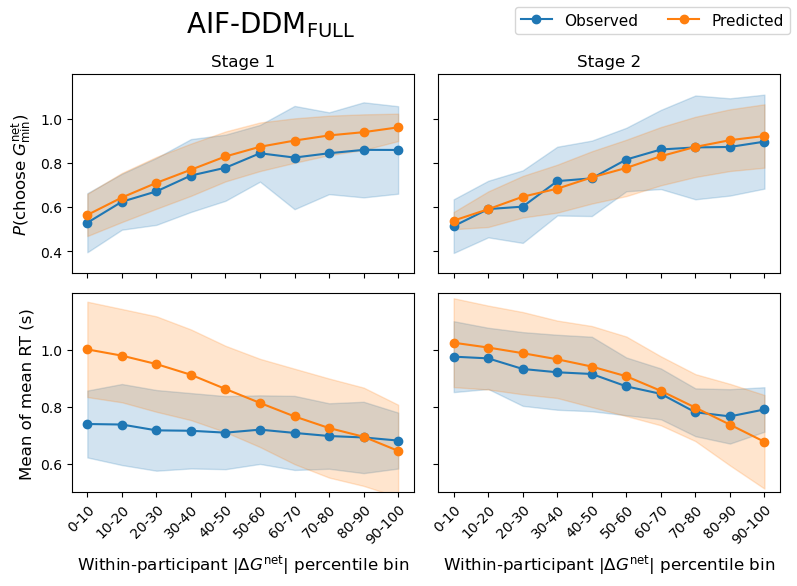

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6)) # Adjusted figsize for better spacing

# --- Define common elements ---
xlabel_common = r"Within-participant $|\Delta G^{\text{net}}|$ percentile bin"
y_ticks_rts = np.arange(0.6, 1.01, 0.2)
y_ticks_probs = np.arange(0.4, 1.01, 0.2)
x_positions = np.arange(len(categories))

# --- Plot 1: Stage 1 (P choosing G min) ---
ax = axes[0,0]
line1_emp_s1c, = ax.plot(categories, mean_mean_empirical_choice_AI_ddm_stage_1,
                         label='Observed', linestyle='-', marker='o', zorder=5)
lower_bound = np.array(mean_mean_empirical_choice_AI_ddm_stage_1) - np.array(std_mean_empirical_choice_AI_ddm_stage_1)
upper_bound = np.array(mean_mean_empirical_choice_AI_ddm_stage_1) + np.array(std_mean_empirical_choice_AI_ddm_stage_1)
ax.fill_between(categories, lower_bound, upper_bound, color=line1_emp_s1c.get_color(), alpha=0.2, label='_nolegend_')

line2_sim_s1c, = ax.plot(categories, mean_mean_simulated_choice_AI_ddm_stage_1,
                         label='Predicted', linestyle='-', marker='o', zorder=5)
lower_bound = np.array(mean_mean_simulated_choice_AI_ddm_stage_1) - np.array(std_mean_simulated_choice_AI_ddm_stage_1)
upper_bound = np.array(mean_mean_simulated_choice_AI_ddm_stage_1) + np.array(std_mean_simulated_choice_AI_ddm_stage_1)
ax.fill_between(categories, lower_bound, upper_bound, color=line2_sim_s1c.get_color(), alpha=0.2, label='_nolegend_')

ax.set_ylabel(r"$P(\text{choose} \; G^{\text{net}}_{\text{min}})$", fontsize=12)
ax.set_title("Stage 1", fontsize=12)
ax.tick_params(axis='x', labelbottom=False)
ax.set_xticks(x_positions) # Still set ticks even if labels are off
ax.set_ylim(0.3, 1.2) # Example ylim, adjust as 
ax.set_yticks(y_ticks_probs)
#ax.grid(axis='y', linestyle='-', alpha=0.7)

# --- Plot 2: Stage 2 (P choosing G min) ---
ax = axes[0,1]
ax.plot(categories, mean_mean_empirical_choice_AI_ddm_stage_2,
        label='Observed', linestyle='-', marker='o', zorder=5, color=line1_emp_s1c.get_color()) # Use same color
lower_bound = np.array(mean_mean_empirical_choice_AI_ddm_stage_2) - np.array(std_mean_empirical_choice_AI_ddm_stage_2)
upper_bound = np.array(mean_mean_empirical_choice_AI_ddm_stage_2) + np.array(std_mean_empirical_choice_AI_ddm_stage_2)
ax.fill_between(categories, lower_bound, upper_bound, color=line1_emp_s1c.get_color(), alpha=0.2, label='_nolegend_')

ax.plot(categories, mean_mean_simulated_choice_AI_ddm_stage_2,
        label='Predicted', linestyle='-', marker='o', zorder=5, color=line2_sim_s1c.get_color()) # Use same color
lower_bound = np.array(mean_mean_simulated_choice_AI_ddm_stage_2) - np.array(std_mean_simulated_choice_AI_ddm_stage_2)
upper_bound = np.array(mean_mean_simulated_choice_AI_ddm_stage_2) + np.array(std_mean_simulated_choice_AI_ddm_stage_2)
ax.fill_between(categories, lower_bound, upper_bound, color=line2_sim_s1c.get_color(), alpha=0.2, label='_nolegend_')

ax.tick_params(axis='y', labelleft=False)
ax.tick_params(axis='x', labelbottom=False)
ax.set_xticks(x_positions) # Still set ticks
ax.set_title("Stage 2", fontsize=12)
ax.set_ylim(0.3, 1.2) # Example ylim
ax.set_yticks(y_ticks_probs)
#ax.grid(axis='y', linestyle='-', alpha=0.7)

# --- Plot 3: Stage 1 (Mean mean Reaction Time) ---
ax = axes[1,0]
ax.plot(categories, mean_mean_empirical_rts_AI_ddm_stage_1,
        label='Observed', linestyle='-', marker='o', zorder=5, color=line1_emp_s1c.get_color()) # Use same color
lower_bound = np.array(mean_mean_empirical_rts_AI_ddm_stage_1) - np.array(std_mean_empirical_rts_AI_ddm_stage_1)
upper_bound = np.array(mean_mean_empirical_rts_AI_ddm_stage_1) + np.array(std_mean_empirical_rts_AI_ddm_stage_1)
ax.fill_between(categories, lower_bound, upper_bound, color=line1_emp_s1c.get_color(), alpha=0.2, label='_nolegend_')

ax.plot(categories, mean_mean_simulated_rts_AI_ddm_stage_1,
        label='Predicted', linestyle='-', marker='o', zorder=5, color=line2_sim_s1c.get_color()) # Use same color
lower_bound = np.array(mean_mean_simulated_rts_AI_ddm_stage_1) - np.array(std_mean_simulated_rts_AI_ddm_stage_1)
upper_bound = np.array(mean_mean_simulated_rts_AI_ddm_stage_1) + np.array(std_mean_simulated_rts_AI_ddm_stage_1)
ax.fill_between(categories, lower_bound, upper_bound, color=line2_sim_s1c.get_color(), alpha=0.2, label='_nolegend_')

ax.set_xlabel(xlabel_common, fontsize=12)
ax.set_xticks(x_positions)
ax.set_xticklabels(categories, rotation=45, ha="right", fontsize=10, rotation_mode="anchor")
ax.set_ylabel("Mean of mean RT (s)", fontsize=12) # Simplified y-label
ax.set_ylim(0.5, 1.2) # Example ylim
ax.set_yticks(y_ticks_rts)

# --- Plot 4: Stage 2 (Mean mean Reaction Time) ---
ax = axes[1,1]
ax.plot(categories, mean_mean_empirical_rts_AI_ddm_stage_2,
        label='Observed', linestyle='-', marker='o', zorder=5, color=line1_emp_s1c.get_color()) # Use same color
lower_bound = np.array(mean_mean_empirical_rts_AI_ddm_stage_2) - np.array(std_mean_empirical_rts_AI_ddm_stage_2)
upper_bound = np.array(mean_mean_empirical_rts_AI_ddm_stage_2) + np.array(std_mean_empirical_rts_AI_ddm_stage_2)
ax.fill_between(categories, lower_bound, upper_bound, color=line1_emp_s1c.get_color(), alpha=0.2, label='_nolegend_')

ax.plot(categories, mean_mean_simulated_rts_AI_ddm_stage_2,
        label='Predicted', linestyle='-', marker='o', zorder=5, color=line2_sim_s1c.get_color()) # Use same color
lower_bound = np.array(mean_mean_simulated_rts_AI_ddm_stage_2) - np.array(std_mean_simulated_rts_AI_ddm_stage_2)
upper_bound = np.array(mean_mean_simulated_rts_AI_ddm_stage_2) + np.array(std_mean_simulated_rts_AI_ddm_stage_2)
ax.fill_between(categories, lower_bound, upper_bound, color=line2_sim_s1c.get_color(), alpha=0.2, label='_nolegend_')

ax.tick_params(axis='y', labelleft=False)
ax.set_xlabel(xlabel_common, fontsize=12)
ax.set_xticks(x_positions)
ax.set_xticklabels(categories, rotation=45, ha="right", fontsize=10, rotation_mode="anchor")
ax.set_ylim(0.5, 1.2) # Example ylim
ax.set_yticks(y_ticks_rts)

# --- Create a single legend for the entire figure ---
# Get handles and labels from one of the subplots (e.g., the first one)
# We need to make sure we get handles for lines that are actually labeled for the legend.
# The handles 'line1_emp_s1c' and 'line2_sim_s1c' from the first plot are good candidates.
handles = [line1_emp_s1c, line2_sim_s1c]
labels = [h.get_label() for h in handles]

leg = fig.legend(
    handles,
    labels,
    loc='upper right', # Change loc to control placement of items relative to bbox_to_anchor
    ncol=2,           # Example: single column for items
    fontsize=11
)

if mtype == 0:  
    model_string = r"$\text{AIF-DDM}_{\text{FULL}}$"
elif mtype == 1:
    model_string = r"$\text{AIF-DDM}_{\text{NSD}}$"
elif mtype == 2:
    model_string = r"$\text{AIF-DDM}_{\text{NUD}}$"
elif mtype == 3:
    model_string = r"$\text{AIF-DDM}_{\text{NSL}}$"

# Add a separate text annotation to the left of where the legend is placed
fig.text(
    0.45, 1, # X, Y coordinates in figure space (0,0 bottom-left, 1,1 top-right)
    model_string, # Your "title"
    ha='right', # Horizontal alignment
    va='top', # Vertical alignment
    fontsize=20,
    fontweight='bold' # Optional styling
)


# Adjust layout to prevent overlap AND make space for the figure legend
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # rect=[left, bottom, right, top]
                                        # top < 1 creates space at the top for fig.legend

plot_filename = f"simulation_analysis_AI_ddm{mtype}.png" 
output_dir = f"../paper_figures/simulation_analysis/AI_ddm{mtype}" 
       
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
       
full_plot_path = os.path.join(output_dir, plot_filename)

plt.savefig(full_plot_path, dpi=300, bbox_inches='tight')

plt.show()

## Per participant analysis

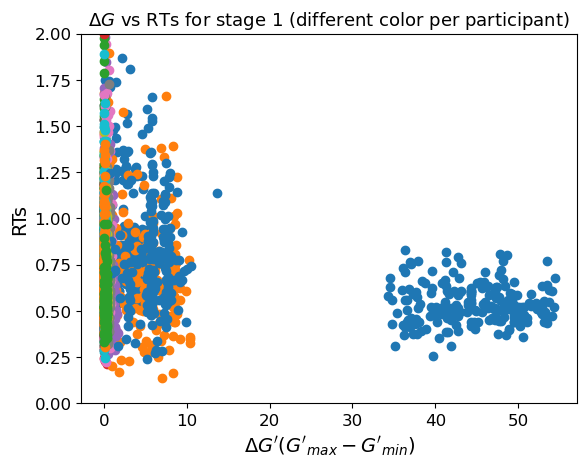

In [37]:
# Analysis per participant
for par in par_ids:
    #print(par)
    plt.scatter(df_AI_ddm_calculations.loc[par,'delta_AI_ddm_G_stage_1'],df_AI_ddm_calculations.loc[par,'empirical_rts_stage_1'])
    #print(np.mean(df_AI_ddm_calculations.loc[par,'delta_AI_ddm_G_stage_1']))
plt.ylabel("RTs" , fontsize=14)
plt.xlabel(r"$\Delta G' (G'_{max} - G'_{min})$", fontsize=14)
plt.title(r"$\Delta G$ vs RTs for stage 1 (different color per participant)", fontsize=13)
plt.tick_params(axis='both', labelsize=12)  # Adjust labelsize as needed
plt.ylim(0,2)
plt.show()

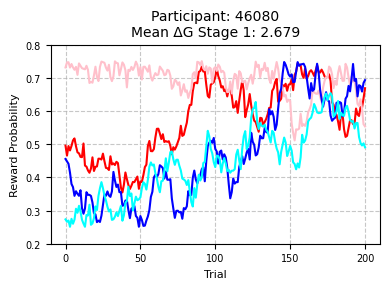

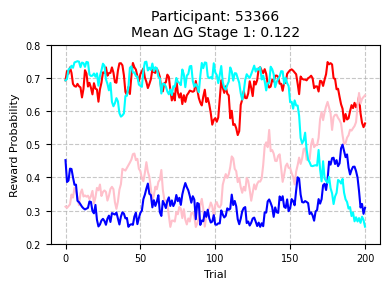

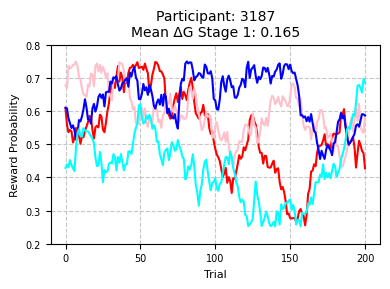

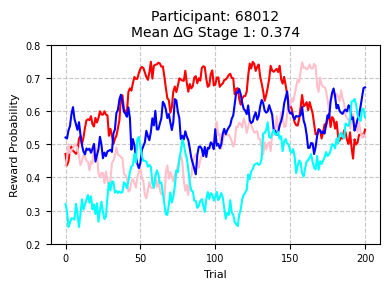

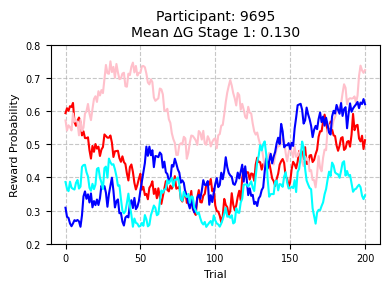

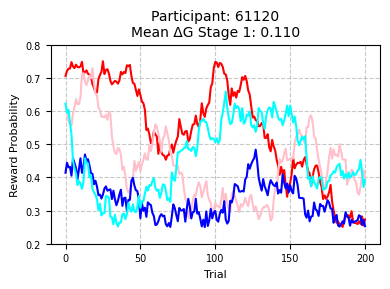

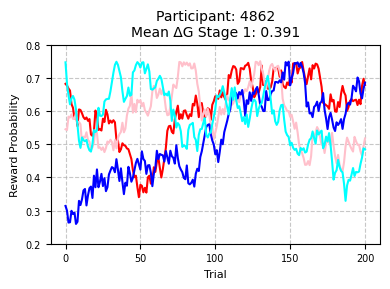

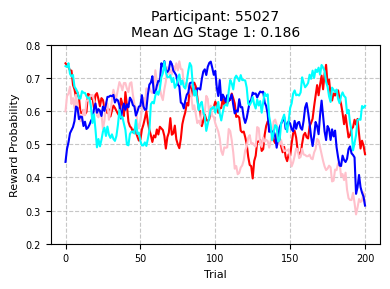

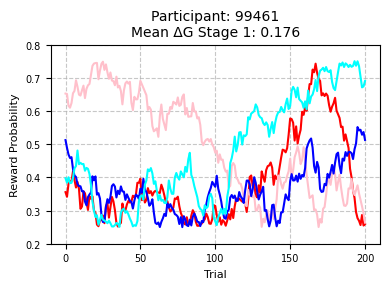

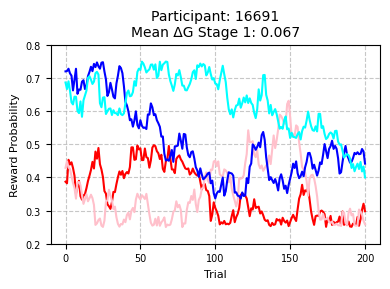

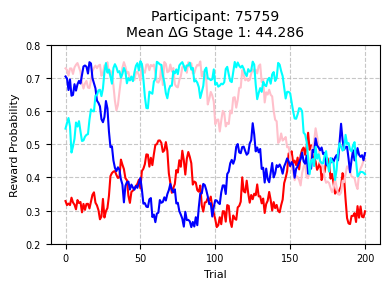

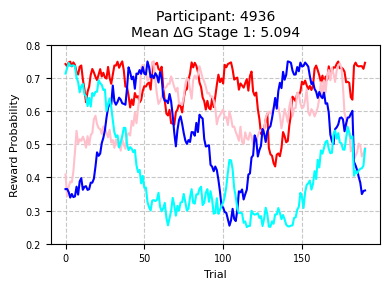

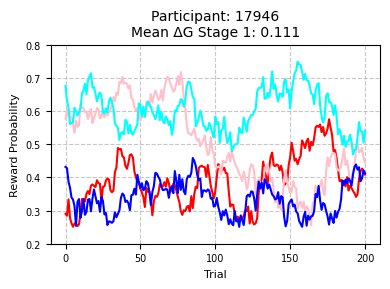

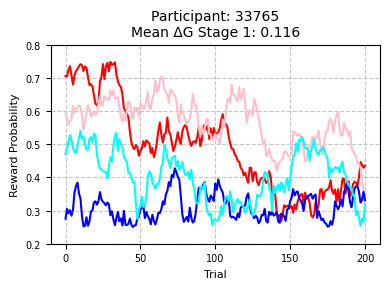

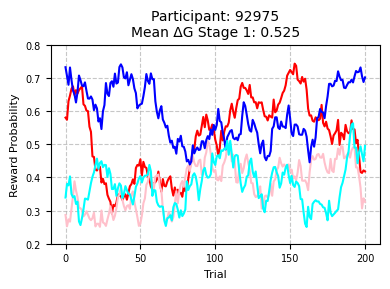

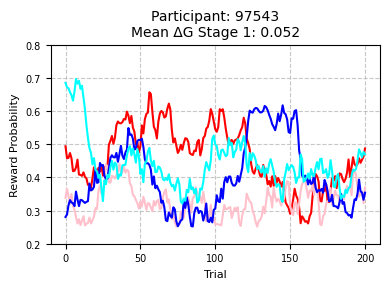

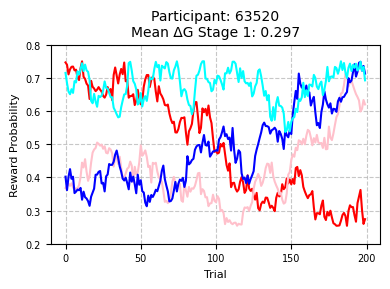

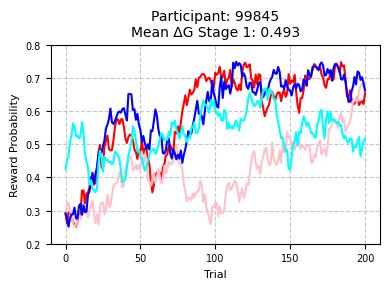

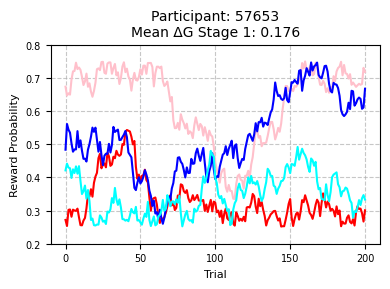

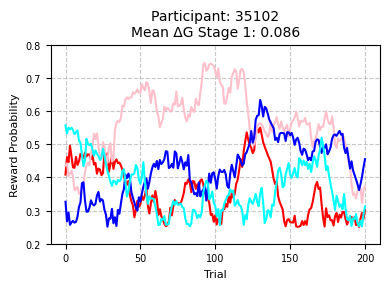

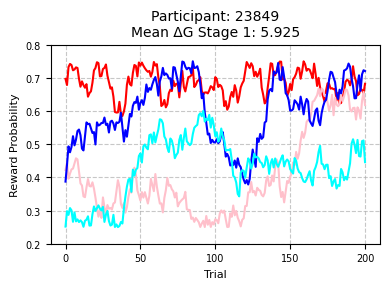

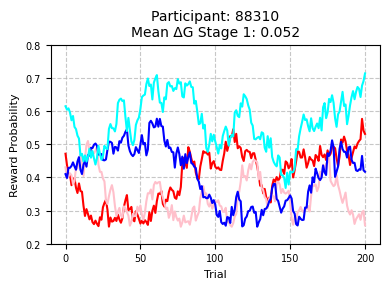

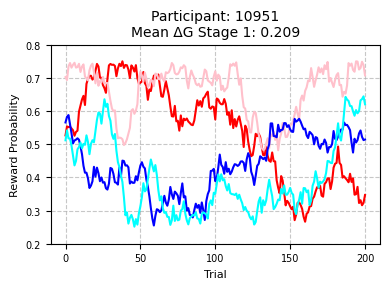

In [38]:
for par in par_ids:
    plt.figure(figsize=(4, 3))
    df_par = df_empirical_data[df_empirical_data['ParticipantID']==par]
    mean_delta_g= np.mean(df_AI_ddm_calculations.loc[par,'delta_AI_ddm_G_stage_1'])
    t = np.arange(len(df_par['reward.1.1'].values))
    plt.plot(t, df_par['reward.1.1'].values,linestyle='-', color = 'red')
    plt.plot(t, df_par['reward.1.2'].values,linestyle='-', color = 'pink')
    plt.plot(t, df_par['reward.2.1'].values,linestyle='-', color = 'blue')
    plt.plot(t, df_par['reward.2.2'].values,linestyle='-', color = 'cyan')

    #plt.plot(t, df_par['reward.1.1'].values + df_par['reward.1.2'].values,linestyle='-', color = 'red')
    #plt.plot(t, df_par['reward.2.1'].values + df_par['reward.2.2'].values,linestyle='-', color = 'blue')
    plt.ylim(0.2,0.8)
    title_string = f"Participant: {par}\nMean ΔG Stage 1: {mean_delta_g:.3f}"
    if np.isnan(mean_delta_g): # Handle case where delta_G was not found
        title_string = f"Participant: {par}\nMean ΔG Stage 1: N/A"
    plt.title(title_string, fontsize=10) # Adjusted fontsize for smaller plot
    plt.xlabel("Trial", fontsize=8)
    plt.ylabel("Reward Probability", fontsize=8)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

#### Correlation between kappa parameter and deltaG

/tmp/ipykernel_17363/1646153462.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  kappa_vals.append(float(df_AI_ddm_fitted_parameters[df_AI_ddm_fitted_parameters['ParticipantID']==par]['Fitted_kappa_a']))


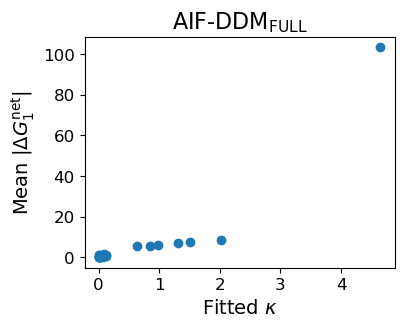

In [39]:
mean_delta_G = []
kappa_vals = []
mean_rts = []

for par in par_ids:
    kappa_vals.append(float(df_AI_ddm_fitted_parameters[df_AI_ddm_fitted_parameters['ParticipantID']==par]['Fitted_kappa_a']))
    mean_delta_G.append(np.mean(df_AI_ddm_calculations.loc[par,'delta_AI_ddm_G_stage_1']))
    #mean_rts.append(np.mean(df_AI_ddm_calculations.loc[par,'empirical_rts_stage_1']))



plt.figure(figsize=(4, 3))

if mtype == 0:  
    model_string = r"$\text{AIF-DDM}_{\text{FULL}}$"
elif mtype == 1:
    model_string = r"$\text{AIF-DDM}_{\text{NSD}}$"
elif mtype == 2:
    model_string = r"$\text{AIF-DDM}_{\text{NUD}}$"
elif mtype == 3:
    model_string = r"$\text{AIF-DDM}_{\text{NSL}}$"

plt.title(model_string, fontsize=16)

plt.scatter(kappa_vals,mean_delta_G)
#plt.scatter(mean_rts,mean_delta_G)
#plt.ylim(0,20)
plt.ylabel(r"Mean $|\Delta G^{\text{net}}_1|$" , fontsize=14)
plt.xlabel(r"Fitted $\kappa$", fontsize=14)
#plt.title(r"$\Delta G$ vs RTs for stage 1 (different color per participant)", fontsize=13)
plt.tick_params(axis='both', labelsize=12) 

plot_filename = f"kappa_vs_deltaG_stage_AI_ddm{mtype}.png" 
output_dir = f"../paper_figures/simulation_analysis/AI_ddm{mtype}/" 
       
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
       
full_plot_path = os.path.join(output_dir, plot_filename)

plt.savefig(full_plot_path, dpi=300, bbox_inches='tight')

plt.show()

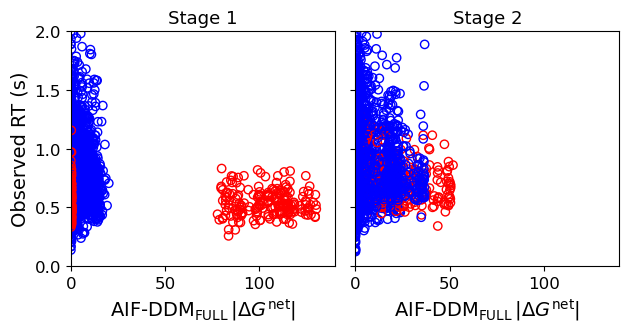

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(6.5, 3.5), sharey=True,sharex=True) # Adjust figsize as needed

if mtype == 0:  
    model_string = r"$\text{AIF-DDM}_{\text{FULL}}$"
elif mtype == 1:
    model_string = r"$\text{AIF-DDM}_{\text{NSD}}$"
elif mtype == 2:
    model_string = r"$\text{AIF-DDM}_{\text{NUD}}$"
elif mtype == 3:
    model_string = r"$\text{AIF-DDM}_{\text{NSL}}$"

# --- Plot 1: On the left (ax[0]) ---
ax[0].set_title("Stage 1", fontsize=13) # Corrected title based on data
for i, par in enumerate(par_ids):
    if par in [75759,10951]:
        par_color = "red"
    else:
        par_color = "blue"

    ax[0].scatter(
        df_AI_ddm_calculations.loc[par, 'delta_AI_ddm_G_stage_1'],
        df_AI_ddm_calculations.loc[par, 'empirical_rts_stage_1'],
        color=par_color, # Cycle through colors
        facecolors='none',
        label=par # Add label for legend if needed
    )
ax[0].set_ylabel("Observed RT (s)", fontsize=14)
ax[0].set_xlabel(model_string + r"$\,|\Delta G^{\text{net}}|$", fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)
ax[0].set_ylim(0, 2)
ax[0].set_xlim(0, 140)
# ax[0].legend() # Uncomment if you want a legend for participants

# --- Plot 2: On the right (ax[1]) ---
ax[1].set_title("Stage 2", fontsize=13) # Corrected title based on data
for i, par in enumerate(par_ids):

    #if par in [75759,10951]:
    if par in [75759]:
        par_color = "red"
    else:
        par_color = "blue"

    ax[1].scatter(
        df_AI_ddm_calculations.loc[par, 'delta_AI_ddm_G_stage_2'],
        df_AI_ddm_calculations.loc[par, 'empirical_rts_stage_2'],
        color=par_color, # Cycle through colors
        facecolors='none',
        linewidth=1,
        label=par # Add label for legend if needed
    )
# If sharey=True, you might not need to set the y-label again,
# or you can set it to an empty string if you prefer.
# ax[1].set_ylabel("RTs" , fontsize=14) # Already set by ax[0] if sharey=True

    
ax[1].set_xlabel(model_string + r"$\,|\Delta G^{\text{net}}|$", fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)


# Add a suptitle for the whole figure (optional)
#fig.suptitle(r"$|\Delta G^{\text{net}}|$ distributions for "+model_string, fontsize=16, y=0.95)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust rect to make space for suptitle if used

plot_filename = f"delta_G_distributions_AI_ddm{mtype}.png" 
output_dir = f"../paper_figures/simulation_analysis/AI_ddm{mtype}/" 
       
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
       
full_plot_path = os.path.join(output_dir, plot_filename)

plt.savefig(full_plot_path, dpi=300, bbox_inches='tight')

plt.show()
    